In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import subprocess
import nltk
# import spacy
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from datetime import datetime

#### File Cleaning

In [23]:
# reading txt files into dataframe of words
transcripts_dir = '/home/congress-user/data_collection/transcripts'
transcripts_df = pd.DataFrame(columns=['date','hearing_num','title','subcommittee','content','present_member','present_staff'])

for subdir, dirs, files in os.walk(transcripts_dir):
    for file in files:
        date, hearing_num = str(file).split('.')[0].split('_')
        date_obj = datetime.strptime(date,'%Y-%m-%d')
        if date_obj >= datetime.strptime('2000-01-01','%Y-%m-%d'):
            # title = titles[titles['serial no.'] == hearing_num]['title'].values[0]
            file_path = os.path.join(subdir,file)
            file = open(file_path,'r')
            full_file = "".join(file.readlines())
            
            # unorganized file omit
            if '[TEXT NOT AVAILABLE REFER TO PDF]' in full_file:
                # example: 116-65
                continue
            elif '[TEXT NOT AVAILABLE]' in full_file:
                # example: 112-132
                continue
            elif '<TEXT NOT AVAILABLE>' in full_file:
                # example: 110-127
                continue
            elif '[NO TEXT AVAILABLE]' in full_file:
                # example: 112-119
                continue
            elif '<TEXT NOT AVAILABLE IN TIFF FORMAT>' in full_file:
                # example: 109-53
                continue
            elif '<TEXT FILE NOT AVAILABLE IN WAIS FORMAT>' in full_file:
                # example: 109-61
                continue
            elif '(Text Not Available In WAIS Format)' in full_file:
                # example: 109-63
                continue
            # elif '[GRAPHIC] [TIFF OMITTED]' in full_file:
            #     # example: 107-82
            #     continue
            # elif '[GRAPHIC(S) NOT AVAILABLE IN TIFF FORMAT]' in full_file:
            #     # example: 112-166
            #     continue
            elif '[ERRATA]' in full_file:
                # example: 109-131
                continue
                
            # extract file title
            try:
                title = full_file.split('<title> -',1)[1].split('</title>')[0].strip()
            except:
                title = ''

            # extract subcommittee
            file_split = full_file.split('COMMITTEE ON ENERGY AND COMMERCE')[0].split('SUBCOMMITTEE ON')
            if len(file_split) == 1:
                subcommittee = ''
            else:
                subcommittee = file_split[1].lower().replace('of the','').replace('\n','').strip()
                if 'committee' in subcommittee:
                    subcommittee = subcommittee.split('committee')[0]
                # if 'committee on energy and commerce house of representatives'
                subcommittee = re.sub(' +', ' ', subcommittee)

            # extract content
            if 'OPENING STATEMENT OF' in full_file:
                content = ''.join(full_file.split('OPENING STATEMENT OF')[1:])
                # content = 'OPENING STATEMENT OF' + content
            elif 'Prepared Statement of' in full_file:
                content = ''.join(full_file.split('Prepared Statement of')[1:])
                # content = 'Prepared Statement of' + content
            else:
                content = ''
                
            # extract member list
            # present members
            if 'Members present:' in full_file:
                members = full_file.split('Members present: ',1)[1]
                if 'Members present:' in members:
                    # example: 109-15 (two days hearing)
                    member1 = members.split('.',1)[0]
                    member2 = members.split('Members present: ',1)[1]
                    members = member1+','+member2
            elif 'Member present:' in full_file:
                members = full_file.split('Member present:',1)[1]
            elif 'Members present from' in full_file:
                members = full_file.split('Members present from',1)[1]
                members = members.split(":",1)[1]
            elif 'Present from' in full_file:
                members = full_file.split('Present from',1)[1]
                members = members.split(":",1)[1]
            elif 'Members resent:' in full_file:
                members = full_file.split('Members resent:',1)[1]
            elif 'Members praesent:' in full_file:
                members = full_file.split('Members praesent:',1)[1]
            elif 'Present:' in full_file:
                members = full_file.split('Present: ',1)[1]
            else:
                # examples: 107-143, 110-141
                present_member = ''
                present_staff = ''
                transcripts_df.loc[len(transcripts_df.index)] = [date, hearing_num, title, subcommittee, content, present_member, present_staff]
                continue
            
            # present staffs
            if 'Staff present:' in members:
                present_member = members.split('Staff present:')[0]
                present_staff = members.split('Staff present:')[1].split('.',1)[0]
            elif 'Staff Present:' in members:
                present_member = members.split('Staff Present:')[0]
                present_staff = members.split('Staff Present:')[1].split('.',1)[0]
            else:
                # members = members.replace('Also present:',)
                if 'Also present:' in members:
                    temp_members = members.split('Also present:')[0]
                    also_present = 'Also present:'+ members.split('Also present:')[1].split('.',1)[0]
                    present_member = temp_members + also_present
                    present_staff = ''
                else:
                    present_member = members.split('.',1)[0]
                    present_staff = ''
            
            # present members
            present_member = present_member.replace('Representatives','').replace('and','').replace(';','').replace('\n','').replace('Representative','')
            if 'Also present:' in present_member:
                member1 = present_member.split('Also present:')[0].strip().replace('.',',')
                member2 = present_member.split('Also present:')[1].strip()
                present_member = member1+member2
            elif 'Also Present:' in present_member:
                member1 = present_member.split('Also Present:')[0].strip().replace('.',',')
                member2 = present_member.split('Also Present:')[1].strip()
                present_member = member1+member2
            present_member = present_member.split(',')
            present_member = [m.replace('.','').strip() for m in present_member]
            
            # present staffs
            present_staff = present_staff.replace('and','').replace('\n','')
            present_staff = present_staff.split(';')
            # present_staff = [m.strip() for m in present_staff]
            present_staff = [tuple(m.strip().split(',')) for m in present_staff]
            # for i in range(len(present_staff)):
            #     # edge case: misuse of ','
            #     if len(present_staff[i]) > 2:
            #         print(file_path)
            #         print(present_staff[i])
            
            # print(content)
            # lines = [re.subn(r'[^A-Za-z0-9 ]+','',line.strip())[0].split(' ') for line in file.readlines() if line.strip()]
            # print(lines)
            # words = [item for sublist in lines for item in sublist]
            
            transcripts_df.loc[len(transcripts_df.index)] = [date, hearing_num, title, subcommittee, content, present_member, present_staff]  
            # break 
    # break
    
# pd.reset_option("all")
transcripts_df

date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1581  2019-05-08      116-31   
1582  2019-05-23      116-39   
1583  2019-04-02      116-20   
1584  2019-10-16      116-69   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1     THE EFFECT OF THE BANKRUPTCY OF ENRON ON THE F...   
2     THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
3     CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
4               DRINKING WATER NEEDS AND INFRASTRUCTURE   
...                                                 ...   
1581  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
1582  SUMMER DRIVING DANGERS: EXPLORING WAYS TO PROT...   
1583  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
1584  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                  subcommittee  \
0     commerce, trade, and consumer protection   
1                       energy and air quality   
2                                       health   
3          telecommunications and the internet   
4          environment and hazardous materials   
...                                        ...   
1581          consumer protection and commerce   
1582          consumer protection and commerce   
1583            environment and climate change   
1584     communications and technology and the   
1585              oversight and investigations   

                                                content  \
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
1      Hon. Joe Barton, Chairman, Subcommittee on En...   
2      Hon. Michael Bilirakis, Chairman, Subcommitte...   
3      Hon. Sherrod Brown, a Representative in Congr...   
4      Public Citizen\n    Public Citizen, a consume...   
...                                                 ...   
1581   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1582   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1583   HON. PAUL TONKO, A REPRESENTATIVE IN \n      ...   
1584   HON. MIKE DOYLE, A REPRESENTATIVE IN \n      ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   

                                         present_member  \
0                    [Stearns, Radanovich, Bass, Towns]   
1     [Barton, Largent, Burr, Shimkus, Pickering, Bl...   
2     [Bilirakis, Upton, Greenwood, Deal, Ganske, No...   
3     [Upton, Barton, Stearns, Gillmor, Cubin, Shimk...   
4     [Gillmor, Shimkus, Wilson, Bass, Pitts, Walden...   
...                                                 ...   
1581  [Schakowsky, Castor, Kelly, O'Halleran, Lujan,...   
1582  [Schakowsky, O'Halleran, Lujan, Cardenas, Blun...   
1583  [Tonko, Clarke, Peters, Barragan, Blunt Roches...   
1584  [Doyle, Schakowsky, Eshoo, DeGette, Matsui, Ca...   
1585  [DeGette, Schakowsky, Kennedy, Ruiz, Kuster, C...   

                                          present_staff  
0     [(Ramsen Betfarhad,  majority counsel,  Yong C...  
1     [(Jason Bentley,  majority counsel), (Sean Cun...  
2     [(Patrick Morrisey,  deputy staff director  co...  
3     [(Linda Bloss-Baum,  majority counsel), (Will ...  
4     [(Bob Meyers,  counsel), (Jerry Couri,  policy...  
...                                                 ...  
1581  [(Billy Benjamin,  Systems Administrator), (Je...  
1582                                     [(Jeffrey C,)]  
1583                                     [(Jeffrey C,)]  
1584               [(AJ Brown,  Counsel), (Jeffrey C,)]  
1585  [(Kevin Barstow,  Chief Oversight Counsel), (B...  

[1586 rows x 7 columns]

##### Subcommittee cleaning

In [24]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# create a list text
text = list(transcripts_df['subcommittee'])

# preprocessing loop
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower().split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

#assign corpus to data['text']
transcripts_df['subcom_corpus'] = corpus
# transcripts_df[transcripts_df['subcom_corpus'].str.contains('energy')]['subcom_corpus'] = 'energy'
conditions= [(transcripts_df['subcom_corpus'].str.contains('energy') | transcripts_df['subcom_corpus'].str.contains('enegy')),
             transcripts_df['subcom_corpus'].str.contains('health'),
             (transcripts_df['subcom_corpus'].str.contains('communication') | transcripts_df['subcom_corpus'].str.contains('communicatons')),
             transcripts_df['subcom_corpus'].str.contains('environment'),
             (transcripts_df['subcom_corpus'].str.contains('commerce') | transcripts_df['subcom_corpus'].str.contains('trade')),]
choices = ['energy','health','communication','environment','commerce']
transcripts_df['subcom_corpus'] = np.select(conditions, choices,default=transcripts_df['subcom_corpus'])

transcripts_df = transcripts_df.drop(columns={'subcommittee'})
transcripts_df = transcripts_df.rename(columns={'subcom_corpus':'subcom'})
transcripts_df

date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1581  2019-05-08      116-31   
1582  2019-05-23      116-39   
1583  2019-04-02      116-20   
1584  2019-10-16      116-69   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1     THE EFFECT OF THE BANKRUPTCY OF ENRON ON THE F...   
2     THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
3     CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
4               DRINKING WATER NEEDS AND INFRASTRUCTURE   
...                                                 ...   
1581  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
1582  SUMMER DRIVING DANGERS: EXPLORING WAYS TO PROT...   
1583  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
1584  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                                content  \
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
1      Hon. Joe Barton, Chairman, Subcommittee on En...   
2      Hon. Michael Bilirakis, Chairman, Subcommitte...   
3      Hon. Sherrod Brown, a Representative in Congr...   
4      Public Citizen\n    Public Citizen, a consume...   
...                                                 ...   
1581   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1582   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1583   HON. PAUL TONKO, A REPRESENTATIVE IN \n      ...   
1584   HON. MIKE DOYLE, A REPRESENTATIVE IN \n      ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   

                                         present_member  \
0                    [Stearns, Radanovich, Bass, Towns]   
1     [Barton, Largent, Burr, Shimkus, Pickering, Bl...   
2     [Bilirakis, Upton, Greenwood, Deal, Ganske, No...   
3     [Upton, Barton, Stearns, Gillmor, Cubin, Shimk...   
4     [Gillmor, Shimkus, Wilson, Bass, Pitts, Walden...   
...                                                 ...   
1581  [Schakowsky, Castor, Kelly, O'Halleran, Lujan,...   
1582  [Schakowsky, O'Halleran, Lujan, Cardenas, Blun...   
1583  [Tonko, Clarke, Peters, Barragan, Blunt Roches...   
1584  [Doyle, Schakowsky, Eshoo, DeGette, Matsui, Ca...   
1585  [DeGette, Schakowsky, Kennedy, Ruiz, Kuster, C...   

                                          present_staff  \
0     [(Ramsen Betfarhad,  majority counsel,  Yong C...   
1     [(Jason Bentley,  majority counsel), (Sean Cun...   
2     [(Patrick Morrisey,  deputy staff director  co...   
3     [(Linda Bloss-Baum,  majority counsel), (Will ...   
4     [(Bob Meyers,  counsel), (Jerry Couri,  policy...   
...                                                 ...   
1581  [(Billy Benjamin,  Systems Administrator), (Je...   
1582                                     [(Jeffrey C,)]   
1583                                     [(Jeffrey C,)]   
1584               [(AJ Brown,  Counsel), (Jeffrey C,)]   
1585  [(Kevin Barstow,  Chief Oversight Counsel), (B...   

                       subcom  
0                    commerce  
1                      energy  
2                      health  
3               communication  
4                 environment  
...                       ...  
1581                 commerce  
1582                 commerce  
1583              environment  
1584            communication  
1585  oversight investigation  

[1586 rows x 7 columns]

In [25]:
# transcripts_df.to_csv('transcripts.csv')

In [3]:
transcripts_df = pd.read_csv('/home/congress-user/data_collection/transcripts.csv')
transcripts_df = transcripts_df.drop(columns=['Unnamed: 0'])
transcripts_df

date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1581  2019-05-08      116-31   
1582  2019-05-23      116-39   
1583  2019-04-02      116-20   
1584  2019-10-16      116-69   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1     THE EFFECT OF THE BANKRUPTCY OF ENRON ON THE F...   
2     THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
3     CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
4               DRINKING WATER NEEDS AND INFRASTRUCTURE   
...                                                 ...   
1581  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
1582  SUMMER DRIVING DANGERS: EXPLORING WAYS TO PROT...   
1583  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
1584  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                                content  \
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
1      Hon. Joe Barton, Chairman, Subcommittee on En...   
2      Hon. Michael Bilirakis, Chairman, Subcommitte...   
3      Hon. Sherrod Brown, a Representative in Congr...   
4      Public Citizen\n    Public Citizen, a consume...   
...                                                 ...   
1581   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1582   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1583   HON. PAUL TONKO, A REPRESENTATIVE IN \n      ...   
1584   HON. MIKE DOYLE, A REPRESENTATIVE IN \n      ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   

                                         present_member  \
0            ['Stearns', 'Radanovich', 'Bass', 'Towns']   
1     ['Barton', 'Largent', 'Burr', 'Shimkus', 'Pick...   
2     ['Bilirakis', 'Upton', 'Greenwood', 'Deal', 'G...   
3     ['Upton', 'Barton', 'Stearns', 'Gillmor', 'Cub...   
4     ['Gillmor', 'Shimkus', 'Wilson', 'Bass', 'Pitt...   
...                                                 ...   
1581  ['Schakowsky', 'Castor', 'Kelly', "O'Halleran"...   
1582  ['Schakowsky', "O'Halleran", 'Lujan', 'Cardena...   
1583  ['Tonko', 'Clarke', 'Peters', 'Barragan', 'Blu...   
1584  ['Doyle', 'Schakowsky', 'Eshoo', 'DeGette', 'M...   
1585  ['DeGette', 'Schakowsky', 'Kennedy', 'Ruiz', '...   

                                          present_staff  \
0     [('Ramsen Betfarhad', ' majority counsel', ' Y...   
1     [('Jason Bentley', ' majority counsel'), ('Sea...   
2     [('Patrick Morrisey', ' deputy staff director ...   
3     [('Linda Bloss-Baum', ' majority counsel'), ('...   
4     [('Bob Meyers', ' counsel'), ('Jerry Couri', '...   
...                                                 ...   
1581  [('Billy Benjamin', ' Systems Administrator'),...   
1582                                   [('Jeffrey C',)]   
1583                                   [('Jeffrey C',)]   
1584         [('AJ Brown', ' Counsel'), ('Jeffrey C',)]   
1585  [('Kevin Barstow', ' Chief Oversight Counsel')...   

                       subcom  
0                    commerce  
1                      energy  
2                      health  
3               communication  
4                 environment  
...                       ...  
1581                 commerce  
1582                 commerce  
1583              environment  
1584            communication  
1585  oversight investigation  

[1586 rows x 7 columns]

In [9]:
temp = transcripts_df.copy()
temp['year'] = pd.to_datetime(temp['date']).dt.year
temp['year'].value_counts()

2013    110
2015    108
2011    106
2009     90
2017     89
2018     85
2019     83
2001     80
2007     78
2014     77
2005     75
2012     75
2008     74
2010     71
2004     71
2016     70
2006     68
2002     62
2003     60
2021     41
2020      9
2023      4
Name: year, dtype: int64

In [11]:
def split_content(row):
    pattern = r'^\s{4}(Mr\.|Ms\.)\s([A-Z][a-z]+)\.'
    try:
        splits = re.split(pattern, str(row['content']), flags=re.MULTILINE)[1:]
        pairs = [(splits[i] + splits[i+1], splits[i+2]) for i in range(0, len(splits), 3)]
        return pairs
    except:
        return None
    
def split_intro(row):
    pattern = r'^\s{4}(Mr\.|Ms\.)\s([A-Z][a-z]+)\.'
    try:
        intro = re.split(pattern, str(row['content']), flags=re.MULTILINE)[0]
        return intro
    except:
        return None

transcripts_df['hearing_word_count'] = transcripts_df['content'].str.split().str.len()
transcripts_df['intro_content'] = transcripts_df.apply(lambda row:split_intro(row), axis=1)
transcripts_df['content_by_speaker'] = transcripts_df.apply(lambda row:split_content(row), axis=1)
transcripts_df = transcripts_df[~transcripts_df['hearing_word_count'].isna()]
transcripts_df['hearing_word_count']  = transcripts_df['hearing_word_count'].astype(int)
transcripts_df

/tmp/ipykernel_3606759/526044377.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df['hearing_word_count']  = transcripts_df['hearing_word_count'].astype(int)


date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1581  2019-05-08      116-31   
1582  2019-05-23      116-39   
1583  2019-04-02      116-20   
1584  2019-10-16      116-69   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1     THE EFFECT OF THE BANKRUPTCY OF ENRON ON THE F...   
2     THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
3     CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
4               DRINKING WATER NEEDS AND INFRASTRUCTURE   
...                                                 ...   
1581  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
1582  SUMMER DRIVING DANGERS: EXPLORING WAYS TO PROT...   
1583  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
1584  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                                content  \
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
1      Hon. Joe Barton, Chairman, Subcommittee on En...   
2      Hon. Michael Bilirakis, Chairman, Subcommitte...   
3      Hon. Sherrod Brown, a Representative in Congr...   
4      Public Citizen\n    Public Citizen, a consume...   
...                                                 ...   
1581   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1582   HON. JAN SCHAKOWSKY, A REPRESENTATIVE IN \n  ...   
1583   HON. PAUL TONKO, A REPRESENTATIVE IN \n      ...   
1584   HON. MIKE DOYLE, A REPRESENTATIVE IN \n      ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   

                                         present_member  \
0            ['Stearns', 'Radanovich', 'Bass', 'Towns']   
1     ['Barton', 'Largent', 'Burr', 'Shimkus', 'Pick...   
2     ['Bilirakis', 'Upton', 'Greenwood', 'Deal', 'G...   
3     ['Upton', 'Barton', 'Stearns', 'Gillmor', 'Cub...   
4     ['Gillmor', 'Shimkus', 'Wilson', 'Bass', 'Pitt...   
...                                                 ...   
1581  ['Schakowsky', 'Castor', 'Kelly', "O'Halleran"...   
1582  ['Schakowsky', "O'Halleran", 'Lujan', 'Cardena...   
1583  ['Tonko', 'Clarke', 'Peters', 'Barragan', 'Blu...   
1584  ['Doyle', 'Schakowsky', 'Eshoo', 'DeGette', 'M...   
1585  ['DeGette', 'Schakowsky', 'Kennedy', 'Ruiz', '...   

                                          present_staff  \
0     [('Ramsen Betfarhad', ' majority counsel', ' Y...   
1     [('Jason Bentley', ' majority counsel'), ('Sea...   
2     [('Patrick Morrisey', ' deputy staff director ...   
3     [('Linda Bloss-Baum', ' majority counsel'), ('...   
4     [('Bob Meyers', ' counsel'), ('Jerry Couri', '...   
...                                                 ...   
1581  [('Billy Benjamin', ' Systems Administrator'),...   
1582                                   [('Jeffrey C',)]   
1583                                   [('Jeffrey C',)]   
1584         [('AJ Brown', ' Counsel'), ('Jeffrey C',)]   
1585  [('Kevin Barstow', ' Chief Oversight Counsel')...   

                       subcom  hearing_word_count  \
0                    commerce               26470   
1                      energy               79736   
2                      health               35576   
3               communication               52083   
4                 environment               61482   
...                       ...                 ...   
1581                 commerce               29628   
1582                 commerce               15989   
1583              environment               35363   
1584            communication               35820   
1585  oversight investigation               31760   

                                          intro_content  \
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
1      Hon. Joe Barton, Chairman, Su

In [11]:
transcripts_df[transcripts_df['hearing_word_count'].isna()]

date hearing_num  \
8     2001-05-01      107-26   
28    2001-03-08      107-19   
51    2001-03-15       107-9   
80    2001-03-20       107-6   
83    2001-05-17      107-27   
...          ...         ...   
814   2006-07-27     109-133   
859   2017-09-14      115-56   
930   2017-11-09      115-77   
1079  2015-07-22      114-68   
1325  2008-07-24     110-141   

                                                  title content  \
8     THE ELECTRICITY EMERGENCY ACT OF 2001 HEARINGS...     NaN   
28    THE EU DATA PROTECTION DIRECTIVE: IMPLICATIONS...     NaN   
51    SMARTER HEALTH CARE PARTNERSHIP FOR AMERICAN F...     NaN   
80                      ELECTRICITY MARKETS: CALIFORNIA     NaN   
83    INCREASE PENALTIES FOR COMMON CARRIER VIOLATIO...     NaN   
...                                                 ...     ...   
814   DISCUSSION DRAFT ON THE PIPELINE SAFETY IMPROV...     NaN   
859   POWERING AMERICA: DEFINING RELIABILITY IN A TR...     NaN   
930             H.R., THE FARM REGULATORY CERTAINTY ACT     NaN   
1079      PROMOTING BROADBAND INFRASTRUCTURE INVESTMENT     NaN   
1325  CARBON SEQUESTRATION: RISKS, OPPORTUNITIES, AN...     NaN   

                                         present_member  \
8                                                   NaN   
28    ['Sterns', 'Deal', 'Shimkus', 'Bryant', 'Buyer...   
51    ['Bilirakis', 'Greenwood', 'Burr', 'Whitfield'...   
80    ['Barton', 'Cox', 'Largent', 'Burr', 'Whitfiel...   
83    ['Upton', 'barton', 'Stearns', 'Deal', 'Largen...   
...                                                 ...   
814   ['Shimkus', 'Sullivan', 'Murphy', 'Boucher', '...   
859   ['Olson', 'Barton', 'Shimkus', 'Murphy', 'Latt...   
930   ['Shimkus', 'McKinley', 'Blackburn', 'Harper',...   
1079  ['Walden', 'Latta', 'Shimkus', 'Scalise', 'Lan...   
1325                                                NaN   

                                          present_staff         subcom  \
8                                                   NaN         energy   
28    [('Ramsen Betfarhad', ' majority counsel'), ('...       commerce   
51    [('Nan Kenkeremath', ' majority counsel'), ('Y...         health   
80    [('Jason Bentley', ' majority counsel'), ('Hol...         energy   
83    [('Howard Waltzman', ' majority counsel'), ('Y...  communication   
...                                                 ...            ...   
814   [('Tom Hassenboehler', ' Counsel'), ('David Mc...         energy   
859   [('Ray Baum', ' Staff Director'), ('Allie Bury...         energy   
930   [('Allie Bury', ' Legislative Clerk', ' Energy...    environment   
1079  [('Ray Baum', ' Senior Policy Advisor', ' Comm...  communication   
1325                                                NaN    environment   

      hearing_word_count intro_content content_by_speaker  
8                    NaN           nan                 []  
28                   NaN           nan                 []  
51                   NaN           nan                 []  
80                   NaN           nan                 []  
83                   NaN           nan                 []  
...                  ...           ...                ...  
814                  NaN           nan                 []  
859                  NaN           nan                 []  
930                  NaN           nan                 []  
1079                 NaN           nan                 []  
1325                 NaN           nan                 []  

[76 rows x 10 columns]

In [21]:
transcripts_df[transcripts_df['content_by_speaker'].isna()]

Empty DataFrame
Columns: [date, hearing_num, title, content, present_member, present_staff, subcom, content_by_speaker]
Index: []

In [21]:
explode_df = transcripts_df.explode(column='content_by_speaker')
explode_df['speaker'] = explode_df['content_by_speaker'].str[0]
explode_df['sentence'] = explode_df['content_by_speaker'].str[1]
explode_df = explode_df.drop(columns=['content_by_speaker'])
explode_df

date hearing_num  \
0     2002-09-26     107-130   
0     2002-09-26     107-130   
0     2002-09-26     107-130   
0     2002-09-26     107-130   
0     2002-09-26     107-130   
...          ...         ...   
1585  2019-09-19      116-62   
1585  2019-09-19      116-62   
1585  2019-09-19      116-62   
1585  2019-09-19      116-62   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
...                                                 ...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                                content  \
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
0      Hon. Clifford Stearns, Chairman, Subcommittee...   
...                                                 ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   
1585   HON. DIANA DeGETTE, A REPRESENTATIVE IN \n   ...   

                                         present_member  \
0            ['Stearns', 'Radanovich', 'Bass', 'Towns']   
0            ['Stearns', 'Radanovich', 'Bass', 'Towns']   
0            ['Stearns', 'Radanovich', 'Bass', 'Towns']   
0            ['Stearns', 'Radanovich', 'Bass', 'Towns']   
0            ['Stearns', 'Radanovich', 'Bass', 'Towns']   
...                                                 ...   
1585  ['DeGette', 'Schakowsky', 'Kennedy', 'Ruiz', '...   
1585  ['DeGette', 'Schakowsky', 'Kennedy', 'Ruiz', '...   
1585  ['DeGette', 'Schakowsky', 'Kennedy', 'Ruiz', '...   
1585  ['DeGette', 'Schakowsky', 'Kennedy', 'Ruiz', '...   
1585  ['DeGette', 'Schakowsky', 'Kennedy', 'Ruiz', '...   

                                          present_staff  \
0     [('Ramsen Betfarhad', ' majority counsel', ' Y...   
0     [('Ramsen Betfarhad', ' majority counsel', ' Y...   
0     [('Ramsen Betfarhad', ' majority counsel', ' Y...   
0     [('Ramsen Betfarhad', ' majority counsel', ' Y...   
0     [('Ramsen Betfarhad', ' majority counsel', ' Y...   
...                                                 ...   
1585  [('Kevin Barstow', ' Chief Oversight Counsel')...   
1585  [('Kevin Barstow', ' Chief Oversight Counsel')...   
1585  [('Kevin Barstow', ' Chief Oversight Counsel')...   
1585  [('Kevin Barstow', ' Chief Oversight Counsel')...   
1585  [('Kevin Barstow', ' Chief Oversight Counsel')...   

                       subcom  hearing_word_count  \
0                    commerce               26470   
0                    commerce               26470   
0                    commerce               26470   
0                    commerce               26470   
0                    commerce               26470   
...                       ...                 ...   
1585  oversight investigation               31760   
1585  oversight investigation               31760   
1585  oversight investigation               31760   
1585  oversight investigation               31760   
1585  oversight investigation               31760   

                                          intro_content        speaker  \
0      Hon. Clifford Stearns, Chairman, Subcommittee...       Mr.Towns   
0     

In [22]:
# explode_df.to_csv('content_by_speaker.csv')
explode_df.to_pickle("content_by_speaker.pkl")  

In [11]:
print(transcripts_df['content'].iloc[1])

 Hon. Joe Barton, Chairman, Subcommittee on Energy 
                            and Air Quality
    There have been many surprises related to Enron, most of them 
unpleasant. Employees lost jobs and in some cases their retirement 
accounts, stockholders generally lost their investment, and creditors 
and other companies had to unwind deals or wait in hopes of payment. I 
am glad that the full Committee and the Oversight Subcommittee are 
doing all they can to explore the many issues surrounding the fall of 
Enron.
    Not all of the surprises have been unpleasant. We knew energy 
markets worked, but I think we were all surprised by the strength they 
showed last fall. Even at the highest point of the crisis, the lights 
stayed on and consumers saw no real price increases. Electricity was 
delivered where it needed to go, and natural gas still arrived on time. 
The biggest market-maker in both electricity and natural gas left the 
market, and the result was nary a blip on reliability an

In [170]:
full_df = transcripts_df.copy()
full_df

date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1581  2019-05-08      116-31   
1582  2019-05-23      116-39   
1583  2019-04-02      116-20   
1584  2019-10-16      116-69   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1     THE EFFECT OF THE BANKRUPTCY OF ENRON ON THE F...   
2     THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
3     CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
4               DRINKING WATER NEEDS AND INFRASTRUCTURE   
...                                                 ...   
1581  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
1582  SUMMER DRIVING DANGERS: EXPLORING WAYS TO PROT...   
1583  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
1584  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                                content  \
0      Ted Cruz, Director, Office of Policy Planning...   
1      Robert McCullough, Managing Partner, McCullou...   
2      College of American Pathologists\n    The Col...   
3      Laura Walker, President and CEO, WNYC\n    Th...   
4      Paul D. Schwartz, National Policy Coordinator...   
...                                                 ...   
1581   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1582   HON. ROBERT E. LATTA, A REPRESENTATIVE IN \n ...   
1583   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1584   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1585   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                                         present_member  \
0                    [Stearns, Radanovich, Bass, Towns]   
1     [Barton, Largent, Burr, Shimkus, Pickering, Bl...   
2     [Bilirakis, Upton, Greenwood, Deal, Ganske, No...   
3     [Upton, Barton, Stearns, Gillmor, Cubin, Shimk...   
4     [Gillmor, Shimkus, Wilson, Bass, Pitts, Walden...   
...                                                 ...   
1581  [Schakowsky, Castor, Kelly, O'Halleran, Lujan,...   
1582  [Schakowsky, O'Halleran, Lujan, Cardenas, Blun...   
1583  [Tonko, Clarke, Peters, Barragan, Blunt Roches...   
1584  [Doyle, Schakowsky, Eshoo, DeGette, Matsui, Ca...   
1585  [DeGette, Schakowsky, Kennedy, Ruiz, Kuster, C...   

                                          present_staff  \
0     [(Ramsen Betfarhad,  majority counsel,  Yong C...   
1     [(Jason Bentley,  majority counsel), (Sean Cun...   
2     [(Patrick Morrisey,  deputy staff director  co...   
3     [(Linda Bloss-Baum,  majority counsel), (Will ...   
4     [(Bob Meyers,  counsel), (Jerry Couri,  policy...   
...                                                 ...   
1581  [(Billy Benjamin,  Systems Administrator), (Je...   
1582                                     [(Jeffrey C,)]   
1583                                     [(Jeffrey C,)]   
1584               [(AJ Brown,  Counsel), (Jeffrey C,)]   
1585  [(Kevin Barstow,  Chief Oversight Counsel), (B...   

                subcom_corpus  
0                    commerce  
1                      energy  
2                      health  
3               communication  
4                 environment  
...                       ...  
1581                 commerce  
1582                 commerce  
1583              environment  
1584            communication  
1585  oversight investigation  

[1586 rows x 7 columns]

##### content filter

In [171]:
# remove names
transcripts_df = transcripts_df[transcripts_df['present_member'] != '']
transcripts_df['cleaned_content'] = transcripts_df['content'].str.replace('\n','').str.lower()
transcripts_df['cleaned_content'] = transcripts_df['cleaned_content'].map(lambda x: re.sub('[,\.!?]', '', x))
transcripts_df['member_list'] = transcripts_df.apply(lambda row:[name.lower() for name in row['present_member']],axis=1)
transcripts_df['staff_list'] = transcripts_df.apply(lambda row:[name[0].split(' ') for name in row['present_staff']],axis=1)
transcripts_df['staff_list'] = transcripts_df['staff_list'].apply(lambda x: [item for sublist in x for item in sublist])
# transcripts_df['cleaned_content'] = transcripts_df.apply(lambda row:re.sub('|'.join(row['member_list']),'',row['cleaned_content']),axis=1)
# transcripts_df['cleaned_content'] = transcripts_df.apply(lambda row:(row.replace(name,'') for name in row['staff_list']),axis=1)
transcripts_df['cleaned_content'] = transcripts_df.apply(lambda row:' '.join([word for word in re.split("\W+",row['cleaned_content']) if word and word.lower() not in row['member_list']]),axis=1)
transcripts_df['cleaned_content'] = transcripts_df.apply(lambda row:' '.join([word for word in re.split("\W+",row['cleaned_content']) if word and word.lower() not in row['staff_list']]),axis=1)
transcripts_df

<>:4: DeprecationWarning: invalid escape sequence \.
<>:10: DeprecationWarning: invalid escape sequence \W
<>:11: DeprecationWarning: invalid escape sequence \W
<>:4: DeprecationWarning: invalid escape sequence \.
<>:10: DeprecationWarning: invalid escape sequence \W
<>:11: DeprecationWarning: invalid escape sequence \W
/tmp/ipykernel_1019062/1623957188.py:4: DeprecationWarning: invalid escape sequence \.
  transcripts_df['cleaned_content'] = transcripts_df['cleaned_content'].map(lambda x: re.sub('[,\.!?]', '', x))
/tmp/ipykernel_1019062/1623957188.py:10: DeprecationWarning: invalid escape sequence \W
  transcripts_df['cleaned_content'] = transcripts_df.apply(lambda row:' '.join([word for word in re.split("\W+",row['cleaned_content']) if word and word.lower() not in row['member_list']]),axis=1)
/tmp/ipykernel_1019062/1623957188.py:11: DeprecationWarning: invalid escape sequence \W
  transcripts_df['cleaned_content'] = transcripts_df.apply(lambda row:' '.join([word for word in re.split(

date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1581  2019-05-08      116-31   
1582  2019-05-23      116-39   
1583  2019-04-02      116-20   
1584  2019-10-16      116-69   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1     THE EFFECT OF THE BANKRUPTCY OF ENRON ON THE F...   
2     THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
3     CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
4               DRINKING WATER NEEDS AND INFRASTRUCTURE   
...                                                 ...   
1581  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
1582  SUMMER DRIVING DANGERS: EXPLORING WAYS TO PROT...   
1583  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
1584  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                                content  \
0      Ted Cruz, Director, Office of Policy Planning...   
1      Robert McCullough, Managing Partner, McCullou...   
2      College of American Pathologists\n    The Col...   
3      Laura Walker, President and CEO, WNYC\n    Th...   
4      Paul D. Schwartz, National Policy Coordinator...   
...                                                 ...   
1581   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1582   HON. ROBERT E. LATTA, A REPRESENTATIVE IN \n ...   
1583   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1584   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1585   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                                         present_member  \
0                    [Stearns, Radanovich, Bass, Towns]   
1     [Barton, Largent, Burr, Shimkus, Pickering, Bl...   
2     [Bilirakis, Upton, Greenwood, Deal, Ganske, No...   
3     [Upton, Barton, Stearns, Gillmor, Cubin, Shimk...   
4     [Gillmor, Shimkus, Wilson, Bass, Pitts, Walden...   
...                                                 ...   
1581  [Schakowsky, Castor, Kelly, O'Halleran, Lujan,...   
1582  [Schakowsky, O'Halleran, Lujan, Cardenas, Blun...   
1583  [Tonko, Clarke, Peters, Barragan, Blunt Roches...   
1584  [Doyle, Schakowsky, Eshoo, DeGette, Matsui, Ca...   
1585  [DeGette, Schakowsky, Kennedy, Ruiz, Kuster, C...   

                                          present_staff  \
0     [(Ramsen Betfarhad,  majority counsel,  Yong C...   
1     [(Jason Bentley,  majority counsel), (Sean Cun...   
2     [(Patrick Morrisey,  deputy staff director  co...   
3     [(Linda Bloss-Baum,  majority counsel), (Will ...   
4     [(Bob Meyers,  counsel), (Jerry Couri,  policy...   
...                                                 ...   
1581  [(Billy Benjamin,  Systems Administrator), (Je...   
1582                                     [(Jeffrey C,)]   
1583                                     [(Jeffrey C,)]   
1584               [(AJ Brown,  Counsel), (Jeffrey C,)]   
1585  [(Kevin Barstow,  Chief Oversight Counsel), (B...   

                subcom_corpus  \
0                    commerce   
1                      energy   
2                      health   
3               communication   
4                 environment   
...                       ...   
1581                 commerce   
1582                 commerce   
1583              environment   
1584            communication   
1585  oversight investigation   

                                        cleaned_content  \
0     ted cruz director office of policy planning fe...   
1     robert mccullough managing partner mccullough ...   
2     college of american pathologists the college o...   
3     laura walker president and ceo wnyc thank you ...   
4     paul d schwartz national policy coordinator cl...   
...                                     

In [172]:
transcripts_df['cleaned_content'] = transcripts_df['cleaned_content'].str.replace('mr.','').str.replace('ms.','').str.replace('chairman','')
transcripts_df

/tmp/ipykernel_1019062/2669494396.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  transcripts_df['cleaned_content'] = transcripts_df['cleaned_content'].str.replace('mr.','').str.replace('ms.','').str.replace('chairman','')
/tmp/ipykernel_1019062/2669494396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df['cleaned_content'] = transcripts_df['cleaned_content'].str.replace('mr.','').str.replace('ms.','').str.replace('chairman','')


date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1581  2019-05-08      116-31   
1582  2019-05-23      116-39   
1583  2019-04-02      116-20   
1584  2019-10-16      116-69   
1585  2019-09-19      116-62   

                                                  title  \
0     STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1     THE EFFECT OF THE BANKRUPTCY OF ENRON ON THE F...   
2     THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
3     CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
4               DRINKING WATER NEEDS AND INFRASTRUCTURE   
...                                                 ...   
1581  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
1582  SUMMER DRIVING DANGERS: EXPLORING WAYS TO PROT...   
1583  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
1584  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   
1585  PROTECTING UNACCOMPANIED CHILDREN: THE ONGOING...   

                                                content  \
0      Ted Cruz, Director, Office of Policy Planning...   
1      Robert McCullough, Managing Partner, McCullou...   
2      College of American Pathologists\n    The Col...   
3      Laura Walker, President and CEO, WNYC\n    Th...   
4      Paul D. Schwartz, National Policy Coordinator...   
...                                                 ...   
1581   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1582   HON. ROBERT E. LATTA, A REPRESENTATIVE IN \n ...   
1583   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1584   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1585   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                                         present_member  \
0                    [Stearns, Radanovich, Bass, Towns]   
1     [Barton, Largent, Burr, Shimkus, Pickering, Bl...   
2     [Bilirakis, Upton, Greenwood, Deal, Ganske, No...   
3     [Upton, Barton, Stearns, Gillmor, Cubin, Shimk...   
4     [Gillmor, Shimkus, Wilson, Bass, Pitts, Walden...   
...                                                 ...   
1581  [Schakowsky, Castor, Kelly, O'Halleran, Lujan,...   
1582  [Schakowsky, O'Halleran, Lujan, Cardenas, Blun...   
1583  [Tonko, Clarke, Peters, Barragan, Blunt Roches...   
1584  [Doyle, Schakowsky, Eshoo, DeGette, Matsui, Ca...   
1585  [DeGette, Schakowsky, Kennedy, Ruiz, Kuster, C...   

                                          present_staff  \
0     [(Ramsen Betfarhad,  majority counsel,  Yong C...   
1     [(Jason Bentley,  majority counsel), (Sean Cun...   
2     [(Patrick Morrisey,  deputy staff director  co...   
3     [(Linda Bloss-Baum,  majority counsel), (Will ...   
4     [(Bob Meyers,  counsel), (Jerry Couri,  policy...   
...                                                 ...   
1581  [(Billy Benjamin,  Systems Administrator), (Je...   
1582                                     [(Jeffrey C,)]   
1583                                     [(Jeffrey C,)]   
1584               [(AJ Brown,  Counsel), (Jeffrey C,)]   
1585  [(Kevin Barstow,  Chief Oversight Counsel), (B...   

                subcom_corpus  \
0                    commerce   
1                      energy   
2                      health   
3               communication   
4                 environment   
...                       ...   
1581                 commerce   
1582                 commerce   
1583              environment   
1584            communication   
1585  oversight investigation   

                                        cleaned_content  \
0     ted cruz director office of policy planning fe...   
1     robert mccullough managing partner mccullough ...   
2     college of american pathologists the college o...   
3     laura walker president and ceo wnyc thank you ...   
4     paul d schwartz national policy coordinator cl...   
...                                     

In [152]:
cleaned_transcript = transcripts_df.copy()
cleaned_transcript = cleaned_transcript.drop(columns={'member_list','staff_list'})
cleaned_transcript

date hearing_num  \
0    2002-09-26     107-130   
1    2002-03-13     107-100   
2    2002-07-10     107-133   
3    2001-05-22      107-36   
4    2001-06-20      107-41   
..          ...         ...   
569  2019-07-16      116-53   
570  2019-10-30      116-77   
571  2019-05-08      116-31   
572  2019-04-02      116-20   
573  2019-10-16      116-69   

                                                 title  \
0    STATE IMPEDIMENTS TO E-COMMERCE: CONSUMER PROT...   
1    THE 2003 BUDGET: A REVIEW OF THE HHS HEALTH CA...   
2    CORPORATION FOR PUBLIC BROADCASTING OVERSIGHT ...   
3                         IMPEDIMENTS TO DIGITAL TRADE   
4    THE HUMAN CLONING PROHIBITION ACT OF 2001 AND ...   
..                                                 ...   
569  OVERSIGHT OF FEDERAL EFFORTS TO COMBAT THE SPR...   
570  BUILDING A 100 PERCENT CLEAN ECONOMY: SOLUTION...   
571  OVERSIGHT OF THE FEDERAL TRADE COMMISSION: STR...   
572  LESSONS FROM ACROSS THE NATION: STATE AND LOCA...   
573  FOSTERING A HEALTHIER INTERNET TO PROTECT CONS...   

                                               content  \
0     Ted Cruz, Director, Office of Policy Planning...   
1     College of American Pathologists\n    The Col...   
2     Laura Walker, President and CEO, WNYC\n    Th...   
3     Debra L. Waggoner, Director, Public Policy, \...   
4     Francis Fukuyama, Omer L. and Nancy Hirst \n ...   
..                                                 ...   
569   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
570   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
571   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
572   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
573   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                                        present_member  \
0                   [Stearns, Radanovich, Bass, Towns]   
1    [Bilirakis, Upton, Greenwood, Deal, Ganske, No...   
2    [Upton, Barton, Stearns, Gillmor, Cubin, Shimk...   
3    [Stearns, Deal, Shimkus, Bryant, Pitts, Walden...   
4    [Bilirakis, Greenwood, Burr, Ganske, Norwood, ...   
..                                                 ...   
569  [DeGette, Schakowsky, Kennedy, Ruiz, Kuster, S...   
570  [Rush, Peters, Doyle, Sarbanes, McNerney, Tonk...   
571  [Schakowsky, Castor, Kelly, O'Halleran, Lujan,...   
572  [Tonko, Clarke, Peters, Barragan, Blunt Roches...   
573  [Doyle, Schakowsky, Eshoo, DeGette, Matsui, Ca...   

                                         present_staff  \
0    [(Ramsen Betfarhad,  majority counsel,  Yong C...   
1    [(Patrick Morrisey,  deputy staff director  co...   
2    [(Linda Bloss-Baum,  majority counsel), (Will ...   
3    [(Ramsen Betfarhad,  majority counsel), (David...   
4    [(Marc Wheat,  majority counsel), (Brent Del M...   
..                                                 ...   
569  [(Mohammad Aslami,  Counsel), (Joe Banez,  Pro...   
570  [(Adam Fischer,  Policy Analyst), (Jean Fruci,...   
571  [(Billy Benjamin,  Systems Administrator), (Je...   
572                                     [(Jeffrey C,)]   
573               [(AJ Brown,  Counsel), (Jeffrey C,)]   

               subcom_corpus  \
0                   commerce   
1                     health   
2              communication   
3                   commerce   
4                     health   
..                       ...   
569  oversight investigation   
570                   energy   
571                 commerce   
572              environment   
573            communication   

                                       cleaned_content  
0    ted cruz director office of policy planning fe...  
1    college of american pathologists the college o...  
2    laura walker president and ceo wnyc thank you ...  
3    debra l waggoner director public policy cornin...  
4    francis fukuyama omer l and nancy hirst profes...  
..                                                 ...  
569  hon greg walden a representative in congress f...  
570  hon 

In [159]:
# transcripts_df.to_csv('cleaned_transcript.csv')

##### Example analysis

In [173]:
test = transcripts_df[transcripts_df['hearing_num'] == '111-113']
test

date hearing_num  \
603  2010-04-28     111-113   

                                                 title  \
603  CLEAN ENERGY POLICIES THAT REDUCE OUR DEPENDEN...   

                                               content  \
603   HON. JERRY MCNERNEY, A REPRESENTATIVE IN \n  ...   

                                        present_member  \
603  [Markey, Doyle, Inslee, Melancon, Matsui, McNe...   

                                         present_staff subcom_corpus  \
603  [(Phil Barnett,  Staff Director), (Bruce Wolpe...        energy   

                                       cleaned_content  \
603  hon jerry a representative in congress from th...   

                                           member_list  \
603  [markey, doyle, inslee, melancon, matsui, mcne...   

                                            staff_list  
603  [Phil, Barnett, Bruce, Wolpe, Greg, Dotson, Lo...

In [174]:
text=' '.join(test['cleaned_content'])
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
nouns

['hon',
 'representative',
 'congress',
 'state',
 'california',
 'thank',
 'today',
 'year',
 'committee',
 'energy',
 'security',
 'act',
 'i',
 'grateful',
 'opportunity',
 'policy',
 'proposals',
 'energy',
 'policies',
 'matter',
 'security',
 'concern',
 'energy',
 'technologies',
 'energy',
 'efficiency',
 'improvements',
 'potential',
 'quality',
 'jobs',
 'i',
 'job',
 'creation',
 'potential',
 'firsthand',
 'experience',
 'power',
 'grid',
 'technologies',
 'times',
 'communities',
 'district',
 'california',
 'edge',
 'energy',
 'businesses',
 'jobs',
 'example',
 'vehicle',
 'facility',
 'stockton',
 'california',
 'workers',
 'port',
 'stockton',
 'business',
 'wind',
 'turbine',
 'parts',
 'jobs',
 'docks',
 'opportunities',
 'job',
 'growth',
 'energy',
 'sector',
 'policies',
 'i',
 'security',
 'benefits',
 'policies',
 'use',
 'energy',
 'resources',
 'years',
 'country',
 'dollars',
 'day',
 'oil',
 'imports',
 'countries',
 'interests',
 'action',
 'energy',
 'reso

/home/congress-user/.local/lib/python3.8/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


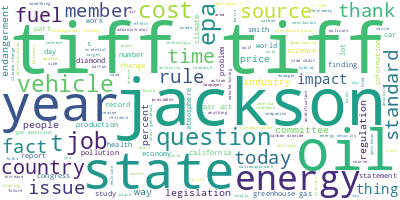

In [175]:
# Import the wordcloud library
from wordcloud import WordCloud

long_string = ','.join(list(nouns))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [176]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = test['cleaned_content'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['hon', 'jerry', 'representative', 'congress', 'state', 'california', 'thank', 'convening', 'today', 'hearing', 'almost', 'year', 'ago', 'committee', 'favorably', 'reported', 'america', 'clean', 'energy', 'security', 'act', 'grateful', 'opportunity', 'evaluate', 'new', 'policy', 'proposals', 'vigorously', 'pursuing', 'well']


[nltk_data] Downloading package stopwords to /home/congress-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [177]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 21), (3, 2), (4, 4), (5, 16), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 2), (16, 1), (17, 4), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 3), (26, 6), (27, 11), (28, 1), (29, 1)]


In [178]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"jackson" + 0.008*"graphic" + 0.008*"omitted" + 0.008*"tiff" + '
  '0.007*"would" + 0.007*"oil" + 0.005*"energy" + 0.005*"epa" + 0.005*"thank" '
  '+ 0.005*"us"'),
 (1,
  '0.013*"would" + 0.010*"omitted" + 0.009*"jackson" + 0.009*"tiff" + '
  '0.008*"thank" + 0.007*"think" + 0.007*"oil" + 0.006*"graphic" + '
  '0.005*"energy" + 0.005*"know"'),
 (2,
  '0.012*"would" + 0.008*"omitted" + 0.008*"graphic" + 0.008*"jackson" + '
  '0.008*"tiff" + 0.007*"oil" + 0.006*"energy" + 0.005*"know" + 0.005*"going" '
  '+ 0.005*"epa"'),
 (3,
  '0.012*"would" + 0.012*"jackson" + 0.011*"graphic" + 0.009*"tiff" + '
  '0.007*"omitted" + 0.007*"energy" + 0.007*"think" + 0.006*"thank" + '
  '0.006*"epa" + 0.005*"oil"'),
 (4,
  '0.011*"jackson" + 0.010*"tiff" + 0.010*"graphic" + 0.009*"omitted" + '
  '0.007*"oil" + 0.007*"would" + 0.007*"energy" + 0.007*"think" + '
  '0.006*"thank" + 0.006*"epa"'),
 (5,
  '0.011*"would" + 0.009*"graphic" + 0.008*"omitted" + 0.008*"jackson" + '
  '0.008*"tiff" + 

In [179]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/home/congress-user/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.001404 -0.001380       1        1  87.066771
3     -0.001751 -0.000804       2        1   7.777274
1     -0.001197  0.002070       3        1   4.190397
7     -0.000202 -0.001691       4        1   0.783627
5     -0.000623  0.000420       5        1   0.083113
8     -0.000424  0.000143       6        1   0.067426
9     -0.000326  0.000987       7        1   0.029369
2      0.000769  0.000660       8        1   0.000674
0      0.002648 -0.000424       9        1   0.000674
6      0.002512  0.000020      10        1   0.000674, topic_info=              Term        Freq       Total Category  logprob  loglift
1555       jackson  159.000000  159.000000  Default  30.0000  30.0000
2865          tiff  145.000000  145.000000  Default  29.0000  29.0000
1278       graphic  142.000000  142.000000  Default  28.0000  28.0000
1942       omitted  134.000000  134.000000  Default  27.0000  27.0000
3139         would  113.000000  113.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1114       finding    0.000328   71.080300  Topic10  -5.7227  -0.3783
642           cost    0.000278   49.937942  Topic10  -5.8879  -0.1905
934   endangerment    0.000284   61.469495  Topic10  -5.8673  -0.3777
2615         smith    0.000267   48.074198  Topic10  -5.9298  -0.1944
1283    greenhouse    0.000263   53.534343  Topic10  -5.9442  -0.3163

[802 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         1  0.850734        able
2         2  0.060767        able
2         3  0.060767        able
5         1  0.863541  absolutely
5         2  0.078504  absolutely
...     ...       ...         ...
3151      1  0.833024         yes
3151      2  0.108655         yes
3151      3  0.036218         yes
3152      1  0.899350         yet
3152      2  0.112419         yet

[695 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 8, 6, 9, 10, 3, 1, 7])

In [180]:
from sklearn.feature_extraction.text import CountVectorizer
# Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english')
# matrix of token counts
X = cv.fit_transform(test['cleaned_content'].values)
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

In [181]:
import pandas as pd
names = cv.get_feature_names_out() # This are the entity names (i.e. keywords)
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
# df.to_csv('to gephi.csv', sep = ',')
df

00  028  05  10  100  1000  100000  11  111  12  ...  year  years  \
00        0    4   2   7    9     1       2   2    1   4  ...    30     45   
028       4    0   8  28   36     4       8   8    4  16  ...   120    180   
05        2    8   0  14   18     2       4   4    2   8  ...    60     90   
10        7   28  14   0   63     7      14  14    7  28  ...   210    315   
100       9   36  18  63    0     9      18  18    9  36  ...   270    405   
...      ..  ...  ..  ..  ...   ...     ...  ..  ...  ..  ...   ...    ...   
youtube   2    8   4  14   18     2       4   4    2   8  ...    60     90   
yucca     1    4   2   7    9     1       2   2    1   4  ...    30     45   
zero      5   20  10  35   45     5      10  10    5  20  ...   150    225   
zeroed    1    4   2   7    9     1       2   2    1   4  ...    30     45   
zillion   1    4   2   7    9     1       2   2    1   4  ...    30     45   

         yes  yield  york  youtube  yucca  zero  zeroed  zillion  
00        38     17     1        2      1     5       1        1  
028      152     68     4        8      4    20       4        4  
05        76     34     2        4      2    10       2        2  
10       266    119     7       14      7    35       7        7  
100      342    153     9       18      9    45       9        9  
...      ...    ...   ...      ...    ...   ...     ...      ...  
youtube   76     34     2        0      2    10       2        2  
yucca     38     17     1        2      0     5       1        1  
zero     190     85     5       10      5     0       5        5  
zeroed    38     17     1        2      1     5       0        1  
zillion   38     17     1        2      1     5       1        0  

[3311 rows x 3311 columns]

In [182]:
df.sort_values('gas',ascending=False)['gas'].head(20)

jackson         8448
omitted         7584
tiff            7584
graphic         7584
oil             5280
thank           5136
energy          5136
think           4992
epa             4512
just            4128
know            3936
going           3792
finding         3360
time            3312
endangerment    3264
clean           3216
cost            2976
gentleman       2832
don             2736
right           2736
Name: gas, dtype: int64

##### Title Analysis

In [183]:
text=' '.join(transcripts_df['title'].values)
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
nouns

['STATE',
 'IMPEDIMENTS',
 'E-COMMERCE',
 'CONSUMER',
 'PROTECTION',
 'OR',
 'VEILED',
 'PROTECTIONISM',
 'THE',
 'EFFECT',
 'THE',
 'BANKRUPTCY',
 'OF',
 'ENRON',
 'ON',
 'THE',
 'FUNCTIONING',
 'OF',
 'ENERGY',
 'MARKETS',
 'THE',
 'BUDGET',
 'REVIEW',
 'THE',
 'HHS',
 'HEALTH',
 'CARE',
 'PRIORITIES',
 'CORPORATION',
 'FOR',
 'PUBLIC',
 'BROADCASTING',
 'OVERSIGHT',
 'A',
 'LOOK',
 'INTO',
 'PUBLIC',
 'BROADCASTING',
 'IN',
 'THE',
 'DIGITAL',
 'ERA',
 'DRINKING',
 'WATER',
 'NEEDS',
 'AND',
 'INFRASTRUCTURE',
 'IMPEDIMENTS',
 'TO',
 'DIGITAL',
 'TRADE',
 'INSURANCE',
 'COVERAGE',
 'OF',
 'MENTAL',
 'HEALTH',
 'BENEFITS',
 'MODERNIZING',
 'MEDICARE',
 'CONTINUING',
 'CONCERNS',
 'OVER',
 'IMPORTED',
 'PHARMACEUTICALS',
 'THE',
 'HUMAN',
 'CLONING',
 'PROHIBITION',
 'ACT',
 'THE',
 'CLONING',
 'PROHIBITION',
 'ACT',
 'ELECTRIC',
 'TRANSMISSION',
 'POLICY',
 'REGIONAL',
 'TRANSMISSION',
 'ORGANIZATIONS',
 'OPEN',
 'ACCESS',
 'AND',
 'FEDERAL',
 'JURISDICTION',
 'NATIONAL',
 'ENERGY',


/home/congress-user/.local/lib/python3.8/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


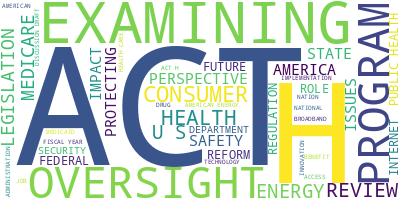

In [184]:
# Import the wordcloud library
from wordcloud import WordCloud

long_string = ','.join(list(nouns))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [185]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = transcripts_df['title'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['state', 'impediments', 'commerce', 'consumer', 'protection', 'veiled', 'protectionism']


[nltk_data] Downloading package stopwords to /home/congress-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [186]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [187]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"health" + 0.026*"act" + 0.019*"care" + 0.016*"public" + '
  '0.011*"examining" + 0.011*"review" + 0.009*"century" + 0.008*"st" + '
  '0.008*"state" + 0.007*"impact"'),
 (1,
  '0.013*"energy" + 0.011*"health" + 0.011*"safety" + 0.009*"public" + '
  '0.009*"issues" + 0.008*"program" + 0.008*"climate" + 0.008*"act" + '
  '0.007*"internet" + 0.006*"waste"'),
 (2,
  '0.043*"act" + 0.022*"energy" + 0.011*"policy" + 0.009*"health" + '
  '0.009*"examining" + 0.009*"federal" + 0.009*"clean" + 0.009*"issues" + '
  '0.008*"protection" + 0.008*"drug"'),
 (3,
  '0.022*"act" + 0.014*"oversight" + 0.010*"consumer" + 0.009*"role" + '
  '0.009*"communications" + 0.009*"commission" + 0.008*"energy" + '
  '0.008*"federal" + 0.007*"regulatory" + 0.007*"protecting"'),
 (4,
  '0.027*"energy" + 0.020*"act" + 0.013*"drug" + 0.013*"examining" + '
  '0.013*"year" + 0.012*"american" + 0.012*"fiscal" + 0.012*"budget" + '
  '0.011*"federal" + 0.009*"department"'),
 (5,
  '0.016*"act" + 0.012*"draft"

In [188]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/home/congress-user/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.008338 -0.082321       1        1  14.023509
0     -0.072110  0.090728       2        1  12.971954
2      0.015676 -0.061703       3        1  10.862294
9      0.073754 -0.001721       4        1   9.634656
7      0.039180 -0.047031       5        1   9.578619
3      0.052096 -0.001584       6        1   9.419136
6     -0.105416  0.037020       7        1   9.338934
8     -0.012880  0.019740       8        1   9.261264
5      0.084544  0.106915       9        1   7.591699
1     -0.066505 -0.060044      10        1   7.317935, topic_info=                Term        Freq       Total Category  logprob  loglift
15            health  138.000000  138.000000  Default  30.0000  30.0000
9             energy  146.000000  146.000000  Default  29.0000  29.0000
25            public   55.000000   55.000000  Default  28.0000  28.0000
41               act  222.000000  222.000000  Default  27.0000  27.0000
14              care   61.000000   61.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
1           consumer    3.939627   49.415183  Topic10  -5.3073   0.0857
18            review    3.939818   54.897441  Topic10  -5.3072  -0.0195
365   communications    3.642014   43.490545  Topic10  -5.3858   0.1348
123  reauthorization    3.167419   32.874921  Topic10  -5.5255   0.2750
203         security    3.167146   47.499422  Topic10  -5.5255  -0.0930

[818 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
980       3  0.501973  abundance
980       5  0.250987  abundance
64        1  0.207676      abuse
64        2  0.103838      abuse
64        4  0.311514      abuse
...     ...       ...        ...
2072      9  0.594150       york
1380      4  0.594272      young
1279      2  0.615099    zadroga
1279     10  0.307549    zadroga
1786      2  0.806773       zika

[1929 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 10, 8, 4, 7, 9, 6, 2])

In [192]:
from sklearn.feature_extraction.text import CountVectorizer
# Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english')
# matrix of token counts
X = cv.fit_transform(transcripts_df['title'].values)
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

In [193]:
import pandas as pd
names = cv.get_feature_names_out() # This are the entity names (i.e. keywords)
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
# df.to_csv('to gephi.csv', sep = ',')
df

10  100  1009  101  108  1084  11  111  1133  1147  ...  years  york  \
10        0    0     0    0    0     0   0    0     0     0  ...      0     0   
100       0    0     0    0    0     0   0    0     0     0  ...      0     0   
1009      0    0     0    0    0     0   0    0     0     0  ...      0     0   
101       0    0     0    0    0     0   0    0     0     0  ...      0     0   
108       0    0     0    0    0     0   0    0     0     0  ...      0     0   
...      ..  ...   ...  ...  ...   ...  ..  ...   ...   ...  ...    ...   ...   
zadroga   0    0     0    0    0     0   3    0     0     0  ...      0     0   
zero      0    1     0    0    0     0   0    0     0     0  ...      0     0   
zev       0    0     0    0    0     0   0    0     0     0  ...      0     0   
zika      0    0     0    0    0     0   0    0     0     0  ...      0     0   
zone      0    0     0    0    0     0   0    0     0     0  ...      0     0   

         young  youth  yucca  zadroga  zero  zev  zika  zone  
10           0      0      0        0     0    0     0     0  
100          0      0      0        0     1    0     0     0  
1009         0      0      0        0     0    0     0     0  
101          0      0      0        0     0    0     0     0  
108          0      0      0        0     0    0     0     0  
...        ...    ...    ...      ...   ...  ...   ...   ...  
zadroga      0      0      0        0     0    0     0     0  
zero         0      0      0        0     0    0     0     0  
zev          0      0      0        0     0    0     0     0  
zika         0      0      0        0     0    0     0     0  
zone         0      0      0        0     0    0     0     0  

[2561 rows x 2561 columns]

In [194]:
df.sort_values('gas',ascending=False)['gas'].head(20)

greenhouse     11
natural         8
act             7
american        6
epa             6
regulations     5
pipeline        5
emissions       5
energy          5
safety          4
initiative      3
jobs            3
economy         3
standards       3
focus           2
program         2
average         2
oil             2
air             2
discussion      2
Name: gas, dtype: int64

### Topic Modeling

In [ ]:
# reading txt files into dataframe of words
transcripts_dir = '/home/congress-user/data_collection/transcripts'
transcripts_df = pd.DataFrame(columns=['date','hearing_num','subcommittee','content'])

for subdir, dirs, files in os.walk(transcripts_dir):
    for file in files:
        date, hearing_num = str(file).split('.')[0].split('_')
        date_obj = datetime.strptime(date,'%Y-%m-%d')
        if date_obj >= datetime.strptime('2000-01-01','%Y-%m-%d'):
            # title = titles[titles['serial no.'] == hearing_num]['title'].values[0]
            file_path = os.path.join(subdir,file)
            file = open(file_path,'r')
            full_file = "".join(file.readlines())

            # extract subcommittee
            file_split = full_file.split('COMMITTEE ON ENERGY AND COMMERCE')[0].split('SUBCOMMITTEE ON')
            if len(file_split) == 1:
                subcommittee = ''
            else:
                subcommittee = file_split[1].lower().replace('of the','').replace('\n','').strip()
                if 'committee' in subcommittee:
                    subcommittee = subcommittee.split('committee')[0]
                # if 'committee on energy and commerce house of representatives'
                subcommittee = re.sub(' +', ' ', subcommittee)

            # extract content
            if 'OPENING STATEMENT OF' in full_file:
                content = full_file.split('OPENING STATEMENT OF')[-1]
                # content = 'OPENING STATEMENT OF' + content
            else:
                content = full_file.split('Prepared Statement of')[-1]
                # content = 'Prepared Statement of' + content
            # print(content)
            
            # print(content)
            # lines = [re.subn(r'[^A-Za-z0-9 ]+','',line.strip())[0].split(' ') for line in file.readlines() if line.strip()]
            # print(lines)
            # words = [item for sublist in lines for item in sublist]
            transcripts_df.loc[len(transcripts_df.index)] = [date, hearing_num, subcommittee, content]  
            # break 
    # break
    
pd.reset_option("all")
transcripts_df

In [3]:
cleaned_df = transcripts_df.copy()
cleaned_df['content_cleaned'] = cleaned_df['content'].map(lambda x: re.sub('[,\.!?]', '', x))
cleaned_df['content_cleaned'] = cleaned_df['content_cleaned'].map(lambda x: x.lower())
cleaned_df['content_cleaned'] = cleaned_df['content_cleaned'].str.replace('\n','')
cleaned_df

date hearing_num                              subcommittee  \
0     2002-09-26     107-130  commerce, trade, and consumer protection   
1     2002-02-13      107-82                    energy and air quality   
2     2002-03-13     107-100                                    health   
3     2002-07-10     107-133       telecommunications and the internet   
4     2002-04-11     107-107       environment and hazardous materials   
...          ...         ...                                       ...   
1596  2019-05-08      116-31          consumer protection and commerce   
1597  2019-05-23      116-39          consumer protection and commerce   
1598  2019-04-02      116-20            environment and climate change   
1599  2019-10-16      116-69     communications and technology and the   
1600  2019-09-19      116-62              oversight and investigations   

                                                content  \
0      Ted Cruz, Director, Office of Policy Planning...   
1      Robert McCullough, Managing Partner, McCullou...   
2      College of American Pathologists\n    The Col...   
3      Laura Walker, President and CEO, WNYC\n    Th...   
4      Paul D. Schwartz, National Policy Coordinator...   
...                                                 ...   
1596   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1597   HON. ROBERT E. LATTA, A REPRESENTATIVE IN \n ...   
1598   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1599   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1600   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                                        content_cleaned  
0      ted cruz director office of policy planning  ...  
1      robert mccullough managing partner mccullough...  
2      college of american pathologists    the colle...  
3      laura walker president and ceo wnyc    thank ...  
4      paul d schwartz national policy coordinator  ...  
...                                                 ...  
1596   hon greg walden a representative in          ...  
1597   hon robert e latta a representative in       ...  
1598   hon greg walden a representative in          ...  
1599   hon greg walden a representative in          ...  
1600   hon greg walden a representative in          ...  

[1601 rows x 5 columns]

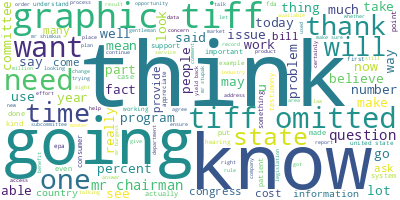

In [6]:
# Import the wordcloud library
from wordcloud import WordCloud

long_string = ','.join(list(cleaned_df['content_cleaned'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [4]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = cleaned_df['content_cleaned'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /home/congress-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ted', 'cruz', 'director', 'office', 'policy', 'planning', 'federal', 'trade', 'commission', 'introduction', 'mr', 'chairman', 'ted', 'cruz', 'director', 'office', 'policy', 'planning', 'federal', 'trade', 'commission', 'sup', 'sup', 'pleased', 'appear', 'subcommittee', 'today', 'testify', 'behalf', 'commission']


In [5]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 5), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 4), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 7), (19, 2), (20, 1), (21, 2), (22, 1), (23, 3), (24, 2), (25, 1), (26, 3), (27, 6), (28, 2), (29, 1)]


In [6]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.028*"mr" + 0.009*"would" + 0.006*"thank" + 0.006*"ms" + 0.005*"think" + '
  '0.005*"one" + 0.004*"going" + 0.004*"well" + 0.004*"get" + 0.004*"like"'),
 (1,
  '0.019*"mr" + 0.008*"would" + 0.007*"think" + 0.007*"thank" + 0.006*"know" + '
  '0.005*"tiff" + 0.005*"omitted" + 0.005*"one" + 0.004*"graphic" + '
  '0.004*"chairman"'),
 (2,
  '0.024*"mr" + 0.009*"would" + 0.008*"think" + 0.006*"thank" + 0.005*"ms" + '
  '0.005*"chairman" + 0.005*"graphic" + 0.005*"omitted" + 0.004*"one" + '
  '0.004*"know"'),
 (3,
  '0.030*"mr" + 0.009*"would" + 0.008*"thank" + 0.006*"think" + 0.004*"ms" + '
  '0.004*"know" + 0.004*"well" + 0.004*"omitted" + 0.004*"one" + 0.004*"like"'),
 (4,
  '0.024*"mr" + 0.009*"would" + 0.006*"thank" + 0.006*"think" + 0.006*"ms" + '
  '0.005*"us" + 0.004*"time" + 0.004*"going" + 0.004*"one" + 0.004*"like"'),
 (5,
  '0.023*"mr" + 0.010*"would" + 0.007*"thank" + 0.006*"think" + 0.005*"us" + '
  '0.005*"know" + 0.005*"ms" + 0.005*"going" + 0.004*"want" + 0.004*"one

In [8]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/home/congress-user/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.003578 -0.000488       1        1  12.360100
3     -0.002440  0.001112       2        1  12.016073
8     -0.000842  0.000896       3        1  11.369692
2     -0.000151  0.002829       4        1  10.795840
5      0.000806 -0.002416       5        1   9.904856
0     -0.000671 -0.002417       6        1   9.483297
4     -0.000165 -0.001481       7        1   9.179698
9      0.001497 -0.000085       8        1   8.813087
1      0.002073  0.003400       9        1   8.046020
7      0.003471 -0.001351      10        1   8.031337, topic_info=         Term           Freq          Total Category  logprob  loglift
4622  omitted   51119.000000   51119.000000  Default  30.0000  30.0000
4721     tiff   56626.000000   56626.000000  Default  29.0000  29.0000
3907       ms   88468.000000   88468.000000  Default  28.0000  28.0000
1650    thank  109533.000000  109533.000000  Default  27.0000  27.0000
4550  graphic   54531.000000   54531.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
1734       us    4764.694609   71000.690053  Topic10  -5.6734  -0.1796
727     going    4437.333674   68279.210241  Topic10  -5.7445  -0.2117
1780     well    3867.447000   66104.876149  Topic10  -5.8820  -0.3168
1675    today    3532.012549   46480.840233  Topic10  -5.9727  -0.0554
1179   people    3553.458956   52679.240686  Topic10  -5.9667  -0.1745

[927 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1          1  0.119804        able
1          2  0.127523        able
1          3  0.143684        able
1          4  0.119398        able
1          5  0.107977        able
...      ...       ...         ...
27043      6  0.064565  zuckerberg
27043      7  0.086914  zuckerberg
27043      8  0.073256  zuckerberg
27043      9  0.034766  zuckerberg
27043     10  0.074498  zuckerberg

[4839 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 9, 3, 6, 1, 5, 10, 2, 8])

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english')
# matrix of token counts
X = cv.fit_transform(cleaned_df['content_cleaned'].values)
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

In [16]:
import pandas as pd
names = cv.get_feature_names_out() # This are the entity names (i.e. keywords)
print(Xc)
# df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
# df.to_csv('to gephi.csv', sep = ',')
# df

  (798, 0)	1
  (60436, 0)	1
  (86185, 0)	1
  (70000, 0)	1
  (77528, 0)	2
  (72890, 0)	1
  (53933, 0)	1
  (4307, 0)	1
  (89831, 0)	1
  (32129, 0)	1
  (27870, 0)	20
  (26764, 0)	11
  (67537, 0)	16
  (77559, 0)	1
  (77560, 0)	1
  (56236, 0)	1
  (90358, 0)	1
  (43679, 0)	2
  (57448, 0)	1
  (55230, 0)	1
  (143137, 0)	2
  (86826, 0)	1
  (136956, 0)	1
  (70581, 0)	1
  (139671, 0)	1
  :	:
  (135512, 145864)	132
  (62192, 145864)	36
  (74864, 145864)	4
  (51248, 145864)	2
  (68977, 145864)	2
  (55482, 145864)	8
  (89107, 145864)	14
  (58342, 145864)	30
  (55641, 145864)	38
  (135520, 145864)	50
  (33464, 145864)	2
  (91654, 145864)	42
  (77816, 145864)	18
  (82723, 145864)	16
  (25669, 145864)	2
  (135345, 145864)	6
  (136676, 145864)	72
  (92734, 145864)	12
  (31055, 145864)	78
  (67894, 145864)	590
  (33506, 145864)	2
  (46292, 145864)	16
  (77413, 145864)	24
  (72075, 145864)	10
  (39826, 145864)	8


#### keyword analysis with example file (111-113)

In [19]:
test = cleaned_df[cleaned_df['hearing_num'] == '111-113']
test

date hearing_num            subcommittee  \
607  2010-04-28     111-113  energy and environment   

                                               content  \
607   HON. JERRY MCNERNEY, A REPRESENTATIVE IN \n  ...   

                                       content_cleaned  
607   hon jerry mcnerney a representative in       ...

In [33]:
text=' '.join(test['content_cleaned'])
tokens = nltk.word_tokenize(text)
tags = nltk.pos_tag(tokens)
nouns = [word for word,pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
nouns

['hon',
 'jerry',
 'representative',
 'congress',
 'state',
 'california',
 'mr',
 'mcnerney',
 'thank',
 'chairman',
 'today',
 'hearing',
 'year',
 'committee',
 'energy',
 'security',
 'act',
 'i',
 'grateful',
 'opportunity',
 'policy',
 'proposals',
 'energy',
 'policies',
 'matter',
 'security',
 'concern',
 'energy',
 'technologies',
 'energy',
 'efficiency',
 'improvements',
 'potential',
 'quality',
 'jobs',
 'i',
 'job',
 'creation',
 'potential',
 'firsthand',
 'experience',
 'power',
 'grid',
 'technologies',
 'times',
 'communities',
 'district',
 'california',
 'edge',
 'energy',
 'businesses',
 'jobs',
 'example',
 'vehicle',
 'facility',
 'stockton',
 'california',
 'workers',
 'port',
 'stockton',
 'business',
 'wind',
 'turbine',
 'parts',
 'jobs',
 'docks',
 'opportunities',
 'job',
 'growth',
 'energy',
 'sector',
 'policies',
 'i',
 'security',
 'benefits',
 'policies',
 'america',
 'use',
 'energy',
 'resources',
 'years',
 'country',
 'dollars',
 'day',
 'oil',
 

/home/congress-user/.local/lib/python3.8/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


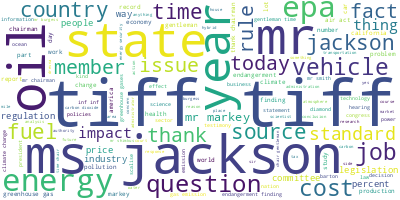

In [34]:
# Import the wordcloud library
from wordcloud import WordCloud

long_string = ','.join(list(nouns))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [21]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = test['content_cleaned'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['hon', 'jerry', 'mcnerney', 'representative', 'congress', 'state', 'california', 'mr', 'mcnerney', 'thank', 'mr', 'chairman', 'convening', 'today', 'hearing', 'almost', 'year', 'ago', 'committee', 'favorably', 'reported', 'america', 'clean', 'energy', 'security', 'act', 'grateful', 'opportunity', 'evaluate', 'new']


[nltk_data] Downloading package stopwords to /home/congress-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 21), (3, 2), (4, 4), (5, 16), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 2), (15, 2), (16, 1), (17, 4), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 3), (26, 6), (27, 11), (28, 1), (29, 1)]


In [23]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"mr" + 0.010*"would" + 0.009*"omitted" + 0.008*"ms" + 0.008*"jackson" '
  '+ 0.007*"graphic" + 0.005*"tiff" + 0.005*"oil" + 0.005*"markey" + '
  '0.005*"thank"'),
 (1,
  '0.031*"mr" + 0.010*"jackson" + 0.009*"would" + 0.007*"tiff" + '
  '0.007*"graphic" + 0.007*"ms" + 0.007*"omitted" + 0.006*"think" + '
  '0.006*"oil" + 0.005*"energy"'),
 (2,
  '0.033*"mr" + 0.011*"ms" + 0.011*"tiff" + 0.011*"would" + 0.011*"jackson" + '
  '0.009*"graphic" + 0.008*"omitted" + 0.007*"think" + 0.006*"thank" + '
  '0.006*"energy"'),
 (3,
  '0.021*"mr" + 0.010*"would" + 0.008*"graphic" + 0.007*"jackson" + '
  '0.007*"omitted" + 0.007*"tiff" + 0.006*"ms" + 0.006*"oil" + 0.005*"energy" '
  '+ 0.005*"markey"'),
 (4,
  '0.027*"mr" + 0.010*"omitted" + 0.010*"jackson" + 0.009*"would" + '
  '0.009*"tiff" + 0.009*"ms" + 0.008*"graphic" + 0.007*"thank" + 0.007*"oil" + '
  '0.006*"energy"'),
 (5,
  '0.028*"mr" + 0.011*"would" + 0.010*"graphic" + 0.010*"omitted" + '
  '0.009*"tiff" + 0.008*"ms" + 0.007*

In [24]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/home/congress-user/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.005584  0.000839       1        1  94.873311
4      0.003673 -0.000772       2        1   5.121678
5      0.002005 -0.001826       3        1   0.000626
8      0.000268  0.000110       4        1   0.000626
7     -0.000010  0.000211       5        1   0.000626
1     -0.000642  0.002257       6        1   0.000626
6     -0.001337 -0.000302       7        1   0.000626
0     -0.002035 -0.000368       8        1   0.000626
9     -0.002771  0.000703       9        1   0.000626
3     -0.004736 -0.000851      10        1   0.000626, topic_info=         Term        Freq       Total Category  logprob  loglift
1858       mr  515.000000  515.000000  Default  30.0000  30.0000
3154    would  173.000000  173.000000  Default  29.0000  29.0000
1860       ms  178.000000  178.000000  Default  28.0000  28.0000
1562  jackson  169.000000  169.000000  Default  27.0000  27.0000
2879     tiff  174.000000  174.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
646      cost    0.000302   63.453468  Topic10  -5.8049  -0.2750
1956      one    0.000300   62.674412  Topic10  -5.8119  -0.2696
2855    think    0.000365  104.034602  Topic10  -5.6151  -0.5796
1599     know    0.000345   91.769526  Topic10  -5.6713  -0.5104
1728     make    0.000272   56.175669  Topic10  -5.9076  -0.2558

[849 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         1  0.832544    ability
3         1  1.082401     abroad
17        1  1.005831  according
23        1  0.864961  achieving
24        1  0.809396   achilles
...     ...       ...        ...
3166      1  0.960734        yes
3166      2  0.058226        yes
3168      1  0.978187      yield
3168      2  0.069871      yield
3169      1  0.801914       york

[462 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 6, 9, 8, 2, 7, 1, 10, 4])

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
# Convert a collection of text documents to a matrix of token counts
cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english')
# matrix of token counts
X = cv.fit_transform(test['content_cleaned'].values)
Xc = (X.T * X) # matrix manipulation
Xc.setdiag(0) # set the diagonals to be zeroes as it's pointless to be 1

In [26]:
import pandas as pd
names = cv.get_feature_names_out() # This are the entity names (i.e. keywords)
df = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)
# df.to_csv('to gephi.csv', sep = ',')
df

00  028  05  10  100  1000  100000  11  111  12  ...  year  years  \
00        0    4   2   7    9     1       2   2    1   4  ...    30     45   
028       4    0   8  28   36     4       8   8    4  16  ...   120    180   
05        2    8   0  14   18     2       4   4    2   8  ...    60     90   
10        7   28  14   0   63     7      14  14    7  28  ...   210    315   
100       9   36  18  63    0     9      18  18    9  36  ...   270    405   
...      ..  ...  ..  ..  ...   ...     ...  ..  ...  ..  ...   ...    ...   
youtube   2    8   4  14   18     2       4   4    2   8  ...    60     90   
yucca     1    4   2   7    9     1       2   2    1   4  ...    30     45   
zero      5   20  10  35   45     5      10  10    5  20  ...   150    225   
zeroed    1    4   2   7    9     1       2   2    1   4  ...    30     45   
zillion   1    4   2   7    9     1       2   2    1   4  ...    30     45   

         yes  yield  york  youtube  yucca  zero  zeroed  zillion  
00        38     17     1        2      1     5       1        1  
028      152     68     4        8      4    20       4        4  
05        76     34     2        4      2    10       2        2  
10       266    119     7       14      7    35       7        7  
100      342    153     9       18      9    45       9        9  
...      ...    ...   ...      ...    ...   ...     ...      ...  
youtube   76     34     2        0      2    10       2        2  
yucca     38     17     1        2      0     5       1        1  
zero     190     85     5       10      5     0       5        5  
zeroed    38     17     1        2      1     5       0        1  
zillion   38     17     1        2      1     5       1        0  

[3325 rows x 3325 columns]

In [30]:
df.sort_values('gas',ascending=False)['gas'].head(20)

mr              24960
jackson          8448
ms               7728
tiff             7584
graphic          7584
omitted          7584
markey           5424
oil              5280
energy           5136
thank            5136
think            4992
epa              4512
just             4128
know             3936
going            3792
chairman         3552
finding          3360
time             3312
endangerment     3264
clean            3216
Name: gas, dtype: int64

### Title Analysis

In [5]:
titles = pd.read_csv('/home/congress-user/data_collection/hearing_metadata.csv')
titles['date'] = pd.to_datetime(titles['date'])
titles = titles[titles['date'] >= '2001-01-01']

conditions= [(titles['date'] >= '2001-01-01') & (titles['date'] < '2005-01-01'), 
             (titles['date'] >= '2005-01-01') & (titles['date'] < '2010-01-01'),
             (titles['date'] >= '2010-01-01') & (titles['date'] < '2015-01-01'),
             (titles['date'] >= '2015-01-01') & (titles['date'] < '2020-01-01'),
             (titles['date'] >= '2020-01-01')]
choices = ['01-05','05-10','10-15','15-20','20-23']
titles['period'] = np.select(conditions, choices)

titles

serial no.       date                                              title  \
0         118-2 2023-02-01  Lives Worth Living: Addressing the Fentanyl Cr...   
1         118-3 2023-02-01  Economic Danger Zone: How America Competes to ...   
2         118-5 2023-02-02  Launching into the State of the Satellite Mark...   
3         118-8 2023-02-08  Liftoff: Unleashing Innovation in Satellite Co...   
4         117-1 2021-02-02  No Time to Lose: Solutions to Increase COVID-1...   
...         ...        ...                                                ...   
1603    107-132 2002-10-09  Recording Industry Marketing Practices: A Chec...   
1604    107-140 2002-10-09  Examining Issues Related to Competition in the...   
1605    107-134 2002-10-17  Ecns and Market Structure: Ensuring Best Price...   
1606    107-139 2002-10-17  Securing America: The Federal Government's Res...   
1607    107-143 2002-12-11          Issues Relating to the Safety of Accutane   

     period  
0     20-23  
1     20-23  
2     20-23  
3     20-23  
4     20-23  
...     ...  
1603  01-05  
1604  01-05  
1605  01-05  
1606  01-05  
1607  01-05  

[1608 rows x 4 columns]

In [6]:
titles['date'].describe()

count                             1608
mean     2011-04-10 07:27:45.671641856
min                2001-02-08 00:00:00
25%                2006-07-18 18:00:00
50%                2011-06-21 12:00:00
75%                2015-10-27 00:00:00
max                2023-02-08 00:00:00
Name: date, dtype: object

#### Tokenization and Lemmatization

In [14]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('all')

# create a list text
text = list(titles['title'])

# preprocessing loop
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower().split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

#assign corpus to data['text']
titles['corpus'] = corpus
titles

NameError: name 'titles' is not defined

#### most common words

/bin/sh: 1: python: not found


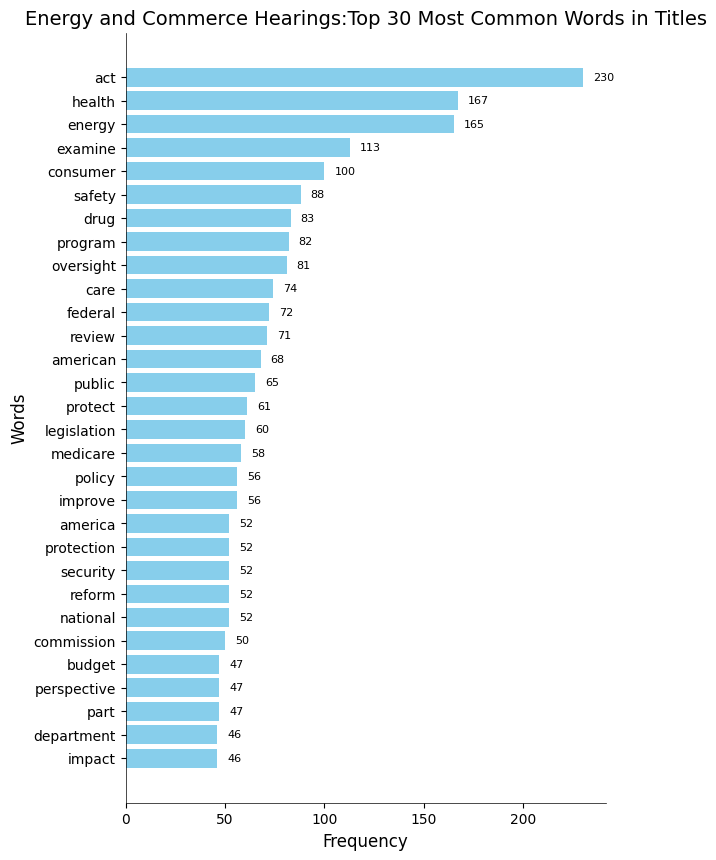

In [8]:
# Download resources
subprocess.run('python -m spacy download en', shell=True)
# nltk.download('punkt')

# Load spaCy model and set stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    words = [word for word in words if word not in stop_words]
    lemmas = [token.lemma_ for token in nlp(" ".join(words))]
    return lemmas

# Aggregate words and create Frecuency Distribution
all_comments = ' '.join(titles['title'])
processed_comments = preprocess_text(all_comments)
fdist = FreqDist(processed_comments)

# Most common words and their frequencies
top_words = fdist.most_common(30)
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Bar plot-Hearing on Energy and Commerce Hearings:Top 30 Most Common Words
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(range(len(words)), frequencies, align='center', color='skyblue')

ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Words', fontsize=12)
ax.set_title('Energy and Commerce Hearings:Top 30 Most Common Words in Titles', fontsize=14)
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words, fontsize=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(axis='x', labelsize=10)
plt.subplots_adjust(left=0.3)

for i, freq in enumerate(frequencies):
    ax.text(freq + 5, i, str(freq), va='center', fontsize=8)

plt.show()

#### title word clouds

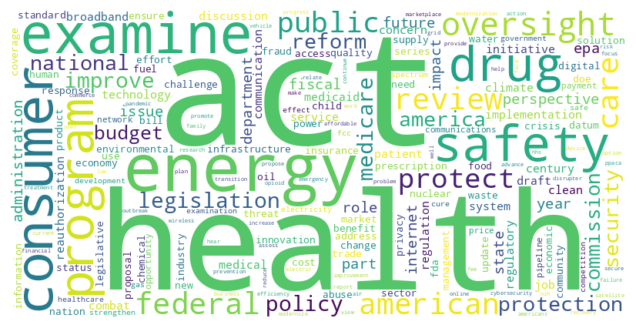

In [9]:
# Word cloud-Senate Hearing on Hearing and Commerce Hearings
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud - Senate Hearing on Oversight of AI')
plt.show()

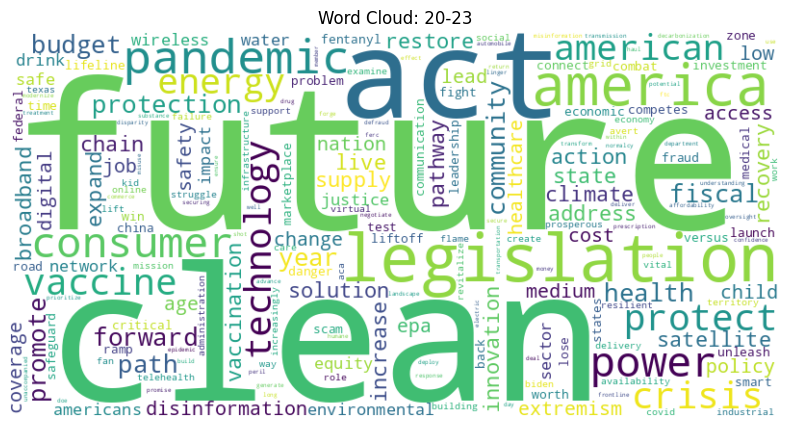

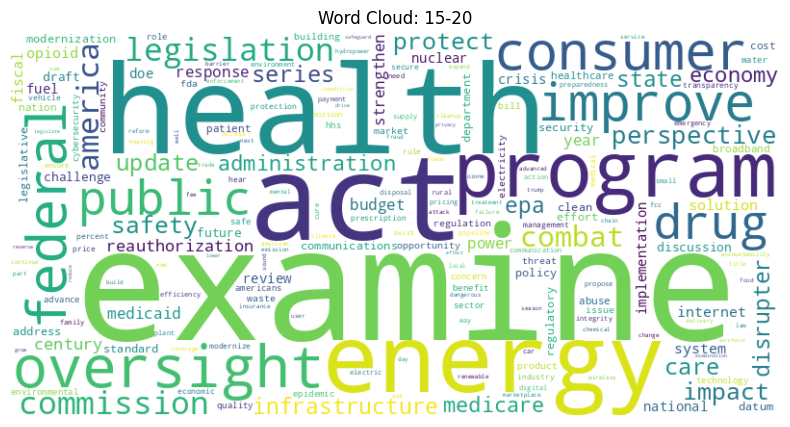

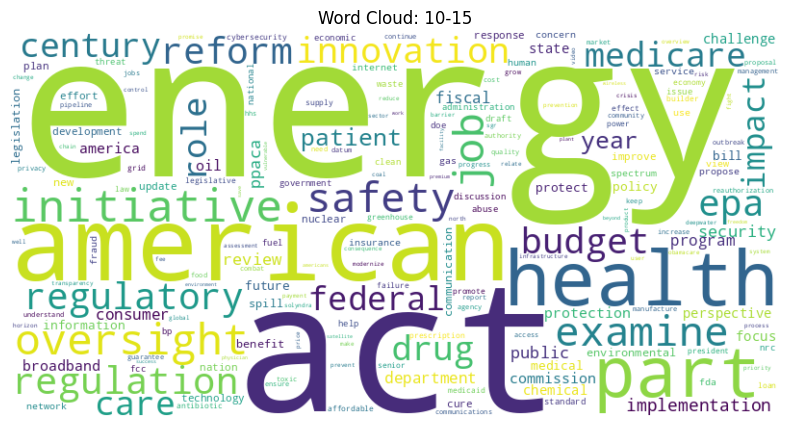

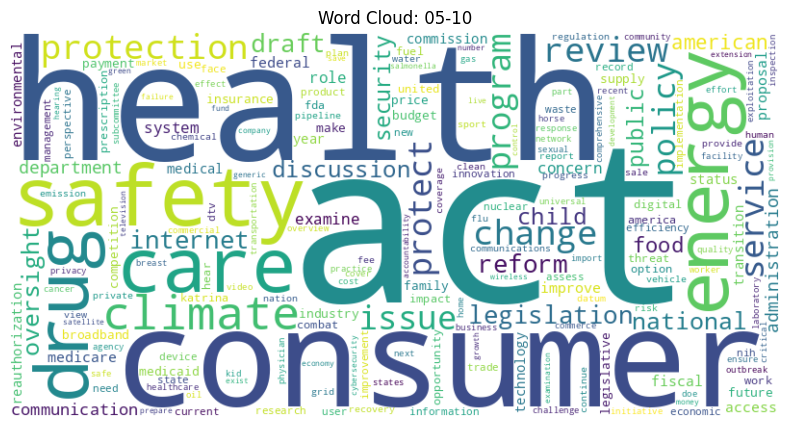

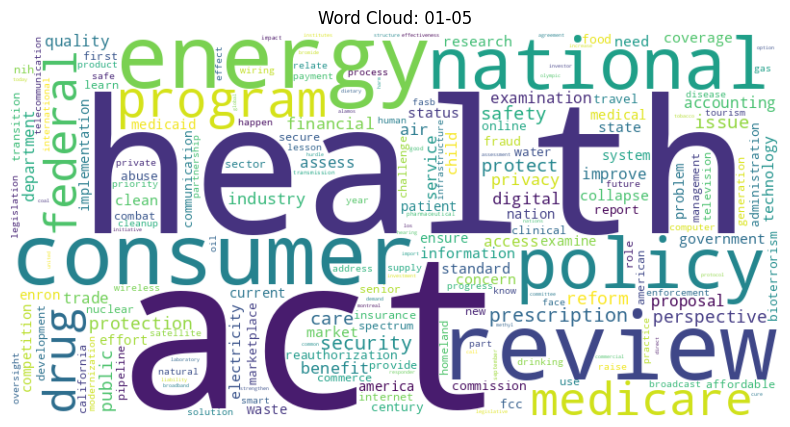

In [10]:
# word cloud by year (5-year period)
periods = titles['period'].unique()
for p in periods:
    comments = titles[titles['period'] == p]['title']
    all_comments = ' '.join(comments)
    processed_comments = preprocess_text(all_comments)
    fdist_organization = FreqDist(processed_comments)

    # Word clouds
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist_organization)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {p}')
    plt.show()

#### title sentiment analysis

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
titles['Sentiment'] = titles['title'].apply(lambda x: sid.polarity_scores(x)['compound'])
titles

serial no.       date                                              title  \
0         118-2 2023-02-01  Lives Worth Living: Addressing the Fentanyl Cr...   
1         118-3 2023-02-01  Economic Danger Zone: How America Competes to ...   
2         118-5 2023-02-02  Launching into the State of the Satellite Mark...   
3         118-8 2023-02-08  Liftoff: Unleashing Innovation in Satellite Co...   
4         117-1 2021-02-02  No Time to Lose: Solutions to Increase COVID-1...   
...         ...        ...                                                ...   
1603    107-132 2002-10-09  Recording Industry Marketing Practices: A Chec...   
1604    107-140 2002-10-09  Examining Issues Related to Competition in the...   
1605    107-134 2002-10-17  Ecns and Market Structure: Ensuring Best Price...   
1606    107-139 2002-10-17  Securing America: The Federal Government's Res...   
1607    107-143 2002-12-11          Issues Relating to the Safety of Accutane   

     period                                             corpus  Sentiment  
0     20-23  life worth living addressing fentanyl crisis p...    -0.6705  
1     20-23  economic danger zone america competes win futu...     0.1027  
2     20-23              launching state satellite marketplace     0.0000  
3     20-23  liftoff unleashing innovation satellite commun...     0.3818  
4     20-23  time lose solution increase covid vaccination ...    -0.2263  
...     ...                                                ...        ...  
1603  01-05        recording industry marketing practice check     0.0000  
1604  01-05  examining issue related competition pharmaceut...     0.0000  
1605  01-05  ecns market structure ensuring best price cons...     0.7430  
1606  01-05  securing america federal government response n...    -0.5106  
1607  01-05                     issue relating safety accutane     0.4215  

[1608 rows x 6 columns]

<Axes: >

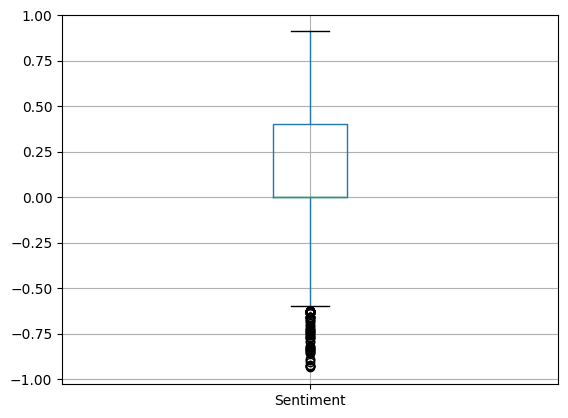

In [13]:
titles.boxplot(column=['Sentiment'])

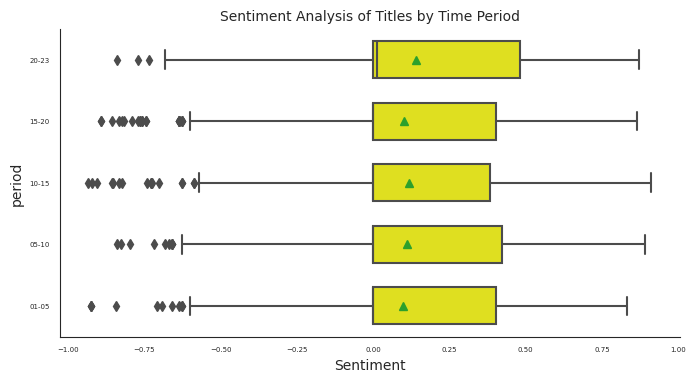

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('white')
plt.figure(figsize=(8, 4))
sns.boxplot(x='Sentiment', y='period', data=titles, color='yellow', 
            width=0.6, showmeans=True, showfliers=True)

# Customize the axis 
def add_cosmetics(title='Sentiment Analysis of Titles by Time Period',
                  xlabel='Sentiment'):
    plt.title(title, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)
    plt.xticks(fontsize=5)
    plt.yticks(fontsize=5)
    sns.despine()

# Apply customized labels to y-axis
# yticks = plt.yticks()[1]
# plt.yticks(ticks=plt.yticks()[0], labels=[customize_labels(label.get_text()) 
#                                           for label in yticks])

add_cosmetics()
plt.show()

In [15]:
# identify negative sentiment titles
q1 = titles['Sentiment'].quantile(0.25)
q3 = titles['Sentiment'].quantile(0.75)
IQR=q3-q1

outliers = titles[((titles['Sentiment']<(q1-1.5*IQR)) | (titles['Sentiment']>(q3+1.5*IQR)))]
pd.set_option('display.max_colwidth', None)
outliers

serial no.       date  \
0         118-2 2023-02-01   
6         117-3 2021-02-04   
15       117-13 2021-03-17   
21       117-17 2021-03-24   
103      116-59 2019-09-11   
...         ...        ...   
1457    108-124 2004-09-22   
1501     107-37 2001-05-23   
1527     107-54 2001-08-28   
1537     107-67 2001-11-06   
1540     107-75 2001-11-15   

                                                                                                    title  \
0     Lives Worth Living: Addressing the Fentanyl Crisis, Protecting Critical Lifelines, and Combating...   
6                           Safeguarding American Consumers: Fighting Fraud and Scams During the Pandemic   
15                             Averting a Crisis: Protecting Access to Healthcare in the U.S. Territories   
21                                                  Power Struggle: Examining the 2021 Texas Grid Failure   
103                                    Protecting and Securing Chemical Facilities from Terrorist Attacks   
...                                                                                                   ...   
1457  Problems with the E-Rate Program: Waste, Fraud, and Abuse Concerns in the Wiring of Our Nation's...   
1501                                                         On-Line Fraud and Crime: Are Consumers Safe?   
1527                                                                         Oxycontin: Its Use and Abuse   
1537                Charitable Contributions for September 11: Protecting Against Fraud, Waste, and Abuse   
1540       Raising Health Awareness Through Examining Benign Brain Tumor Cancer, Alpha One, and Breast...   

     period  \
0     20-23   
6     20-23   
15    20-23   
21    20-23   
103   15-20   
...     ...   
1457  01-05   
1501  01-05   
1527  01-05   
1537  01-05   
1540  01-05   

                                                                                   corpus  \
0     life worth living addressing fentanyl crisis protecting critical lifeline combating   
6                             safeguarding american consumer fighting fraud scam pandemic   
15                               averting crisis protecting access healthcare u territory   
21                                            power struggle examining texas grid failure   
103                                protecting securing chemical facility terrorist attack   
...                                                                                   ...   
1457                       problem e rate program waste fraud abuse concern wiring nation   
1501                                                       line fraud crime consumer safe   
1527                                                                  oxycontin use abuse   
1537                       charitable contribution september protecting fraud waste abuse   
1540        raising health awareness examining benign brain tumor cancer alpha one breast   

      Sentiment  
0       -0.6705  
6       -0.8402  
15      -0.6249  
21      -0.6808  
103     -0.7430  
...         ...  
1457    -0.9260  
1501    -0.6597  
1527    -0.6369  
1537    -0.8442  
1540    -0.6908  

[62 rows x 6 columns]

/tmp/ipykernel_459128/3155754530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['year'] = outliers['date'].dt.to_period('y')


<Axes: xlabel='year'>

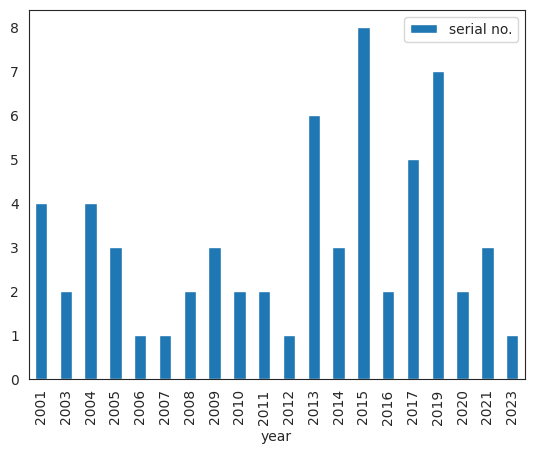

In [16]:
outliers['year'] = outliers['date'].dt.to_period('y')
outliers.groupby(by=['year'])['serial no.'].count().reset_index().plot.bar(x='year',y='serial no.')

#### Oil vs Clean Energy Sentiment

In [17]:
titles['contain_oil'] = titles['corpus'].str.count('oil')
titles['contain_clean'] = titles['corpus'].str.count('clean')
titles['year'] = titles['date'].dt.to_period('y')
titles

serial no.       date  \
0         118-2 2023-02-01   
1         118-3 2023-02-01   
2         118-5 2023-02-02   
3         118-8 2023-02-08   
4         117-1 2021-02-02   
...         ...        ...   
1603    107-132 2002-10-09   
1604    107-140 2002-10-09   
1605    107-134 2002-10-17   
1606    107-139 2002-10-17   
1607    107-143 2002-12-11   

                                                                                                    title  \
0     Lives Worth Living: Addressing the Fentanyl Crisis, Protecting Critical Lifelines, and Combating...   
1                               Economic Danger Zone: How America Competes to Win the Future Versus China   
2                                                   Launching into the State of the Satellite Marketplace   
3                                 Liftoff: Unleashing Innovation in Satellite Communications Technologies   
4                              No Time to Lose: Solutions to Increase COVID-19 Vaccinations in the States   
...                                                                                                   ...   
1603                                                   Recording Industry Marketing Practices: A Check-Up   
1604    Examining Issues Related to Competition in the Pharmaceutical Marketplace: A Review of the FTC...   
1605                                        Ecns and Market Structure: Ensuring Best Prices for Consumers   
1606    Securing America: The Federal Government's Response to Nuclear Terrorism at Our Nation's Ports...   
1607                                                            Issues Relating to the Safety of Accutane   

     period  \
0     20-23   
1     20-23   
2     20-23   
3     20-23   
4     20-23   
...     ...   
1603  01-05   
1604  01-05   
1605  01-05   
1606  01-05   
1607  01-05   

                                                                                   corpus  \
0     life worth living addressing fentanyl crisis protecting critical lifeline combating   
1                           economic danger zone america competes win future versus china   
2                                                   launching state satellite marketplace   
3                        liftoff unleashing innovation satellite communication technology   
4                                     time lose solution increase covid vaccination state   
...                                                                                   ...   
1603                                          recording industry marketing practice check   
1604            examining issue related competition pharmaceutical marketplace review ftc   
1605                                   ecns market structure ensuring best price consumer   
1606           securing america federal government response nuclear terrorism nation port   
1607                                                       issue relating safety accutane   

      Sentiment  contain_oil  contain_clean  year  
0       -0.6705            0              0  2023  
1        0.1027            0              0  2023  
2        0.0000            0              0  2023  
3        0.3818            0              0  2023  
4       -0.2263            0              0  2021  
...         ...          ...            ...   ...  
1603     0.0000            0              0  2002  
1604     0.0000            0              0  2002  
1605     0.7430            0              0  2002  
1606    -0.5106            0              0  2002  
1607     0.4215            0              0  2002  

[1608 rows x 9 columns]

In [18]:
titles_word_count = titles.groupby(by=['year'])[['contain_oil','contain_clean']].sum().reset_index()
titles_word_count

year  contain_oil  contain_clean
0   2001            1              1
1   2002            0              4
2   2003            1              4
3   2004            1              1
4   2005            5              1
5   2006            1              1
6   2007            1              0
7   2008            0              1
8   2009            0              2
9   2010           12              3
10  2011            2              1
11  2012            0              0
12  2013            0              0
13  2014            0              3
14  2015            1              1
15  2016            0              1
16  2017            0              0
17  2018            1              1
18  2019            0             11
19  2020            0              0
20  2021            0             10
21  2023            0              0

In [19]:
titles[(titles['contain_oil']==1) & (titles['contain_clean']==1)]

serial no.       date  \
981    111-113 2010-04-28   

                                                       title period  \
981  Clean Energy Policies that Reduce Our Dependence on Oil  10-15   

                                        corpus  Sentiment  contain_oil  \
981  clean energy policy reduce dependence oil     0.5859            1   

     contain_clean  year  
981              1  2010

In [20]:
# oil and clean energy sentiment analysis
sent_keyword = titles[(titles['contain_oil']==1) | (titles['contain_clean']==1)]
clean_sent = sent_keyword.groupby(by=['contain_clean'])['Sentiment'].mean().reset_index()
clean_sent

contain_clean  Sentiment
0              0   0.087305
1              1   0.451882

In [21]:
oil_sent = sent_keyword.groupby(by=['contain_oil'])['Sentiment'].mean().reset_index()
oil_sent

contain_oil  Sentiment
0            0   0.448446
1            1   0.112235

In [22]:
oil_keywords = ['petroleum','gas','Oil','crude','hydrocarbon','oilfields','hydrocarbons','oilfield','gasoline','deepwater','Petroleum','petro',
 'refineries','barrel','barrels','OIL','Exxon','OPEC','BPBP','Opec','Crude','onshore','oilmen','bpd','refiners','opec','offshore','petrochemical',
 'bitumen','shale','BP','Chevron','butanes','bbl','integrateds','oilwell','refining','unconventionals','deepwaters','Bitumen','OIl','crudes','soybean',
 'LNG','refinery','IOCs','drillers','wellhead','petrochemicals','pipelines']
# titles['contain_oil'] = titles['corpus'].str.count('oil')
# titles['contain_clean'] = titles['corpus'].str.count('clean')
# titles['year'] = titles['date'].dt.to_period('y')
oil_corpous = titles.copy()
is_in_search_list = lambda x: any([s in x for s in oil_keywords])
oil_corpous['oil_corpus'] = titles['corpus'].apply(is_in_search_list)
oil_corpous['clean_corpus'] = titles['corpus'].str.contains('clean energy')
oil_corpous

serial no.       date  \
0         118-2 2023-02-01   
1         118-3 2023-02-01   
2         118-5 2023-02-02   
3         118-8 2023-02-08   
4         117-1 2021-02-02   
...         ...        ...   
1603    107-132 2002-10-09   
1604    107-140 2002-10-09   
1605    107-134 2002-10-17   
1606    107-139 2002-10-17   
1607    107-143 2002-12-11   

                                                                                                    title  \
0     Lives Worth Living: Addressing the Fentanyl Crisis, Protecting Critical Lifelines, and Combating...   
1                               Economic Danger Zone: How America Competes to Win the Future Versus China   
2                                                   Launching into the State of the Satellite Marketplace   
3                                 Liftoff: Unleashing Innovation in Satellite Communications Technologies   
4                              No Time to Lose: Solutions to Increase COVID-19 Vaccinations in the States   
...                                                                                                   ...   
1603                                                   Recording Industry Marketing Practices: A Check-Up   
1604    Examining Issues Related to Competition in the Pharmaceutical Marketplace: A Review of the FTC...   
1605                                        Ecns and Market Structure: Ensuring Best Prices for Consumers   
1606    Securing America: The Federal Government's Response to Nuclear Terrorism at Our Nation's Ports...   
1607                                                            Issues Relating to the Safety of Accutane   

     period  \
0     20-23   
1     20-23   
2     20-23   
3     20-23   
4     20-23   
...     ...   
1603  01-05   
1604  01-05   
1605  01-05   
1606  01-05   
1607  01-05   

                                                                                   corpus  \
0     life worth living addressing fentanyl crisis protecting critical lifeline combating   
1                           economic danger zone america competes win future versus china   
2                                                   launching state satellite marketplace   
3                        liftoff unleashing innovation satellite communication technology   
4                                     time lose solution increase covid vaccination state   
...                                                                                   ...   
1603                                          recording industry marketing practice check   
1604            examining issue related competition pharmaceutical marketplace review ftc   
1605                                   ecns market structure ensuring best price consumer   
1606           securing america federal government response nuclear terrorism nation port   
1607                                                       issue relating safety accutane   

      Sentiment  contain_oil  contain_clean  year  oil_corpus  clean_corpus  
0       -0.6705            0              0  2023       False         False  
1        0.1027            0              0  2023       False         False  
2        0.0000            0              0  2023       False         False  
3        0.3818            0              0  2023       False         False  
4       -0.2263            0              0  2021       False         False  
...         ...          ...            ...   ...         ...           ...  
1603     0.0000            0              0  2002       False         False  
1604     0.0000            0              0  2002       False         False  
1605     0.7430            0              0  2002       False         False  
1606    -0.5106            0              0  2002       False         False  
1607     0.4215            0              0  2002       False         False  

[1608 rows x 11 columns]

<Axes: >

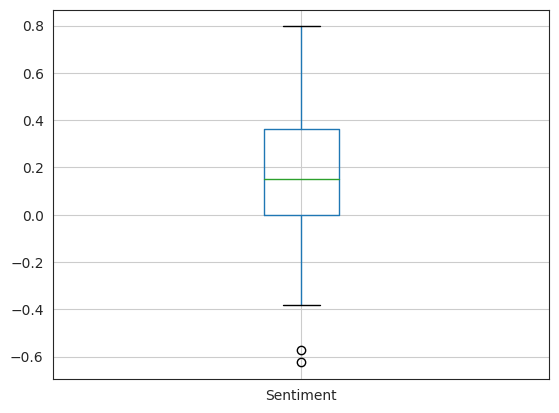

In [23]:
oil_corpous[oil_corpous['oil_corpus'] == True].boxplot(column='Sentiment')

<Axes: >

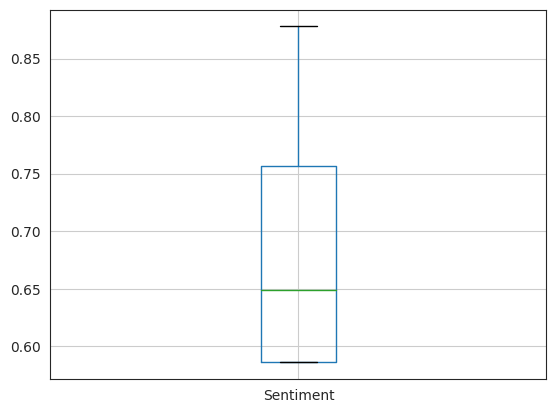

In [24]:
oil_corpous[oil_corpous['clean_corpus'] == True].boxplot(column='Sentiment')

#### Content Analysis

In [12]:
# reading txt files into dataframe of words
transcripts_dir = '/home/congress-user/data_collection/transcripts'
transcripts_df = pd.DataFrame(columns=['date','hearing_num','subcommittee','content'])

for subdir, dirs, files in os.walk(transcripts_dir):
    for file in files:
        date, hearing_num = str(file).split('.')[0].split('_')
        date_obj = datetime.strptime(date,'%Y-%m-%d')
        if date_obj >= datetime.strptime('2000-01-01','%Y-%m-%d'):
            # title = titles[titles['serial no.'] == hearing_num]['title'].values[0]
            file_path = os.path.join(subdir,file)
            file = open(file_path,'r')
            full_file = "".join(file.readlines())

            # extract subcommittee
            file_split = full_file.split('COMMITTEE ON ENERGY AND COMMERCE')[0].split('SUBCOMMITTEE ON')
            if len(file_split) == 1:
                subcommittee = ''
            else:
                subcommittee = file_split[1].lower().replace('of the','').replace('\n','').strip()
                if 'committee' in subcommittee:
                    subcommittee = subcommittee.split('committee')[0]
                # if 'committee on energy and commerce house of representatives'
                subcommittee = re.sub(' +', ' ', subcommittee)

            # extract content
            if 'OPENING STATEMENT OF' in full_file:
                content = full_file.split('OPENING STATEMENT OF')[-1]
                # content = 'OPENING STATEMENT OF' + content
            else:
                content = full_file.split('Prepared Statement of')[-1]
                # content = 'Prepared Statement of' + content
            # print(content)
            
            # print(content)
            # lines = [re.subn(r'[^A-Za-z0-9 ]+','',line.strip())[0].split(' ') for line in file.readlines() if line.strip()]
            # print(lines)
            # words = [item for sublist in lines for item in sublist]
            transcripts_df.loc[len(transcripts_df.index)] = [date, hearing_num, subcommittee, content]  
            # break 
    # break
    
pd.reset_option("all")
transcripts_df

/tmp/ipykernel_3606759/3445714686.py:43: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option("all")
/tmp/ipykernel_3606759/3445714686.py:43: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option("all")
/tmp/ipykernel_3606759/3445714686.py:43: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option("all")


date hearing_num                              subcommittee  \
0     2002-09-26     107-130  commerce, trade, and consumer protection   
1     2002-02-13      107-82                    energy and air quality   
2     2002-03-13     107-100                                    health   
3     2002-07-10     107-133       telecommunications and the internet   
4     2002-04-11     107-107       environment and hazardous materials   
...          ...         ...                                       ...   
1596  2019-05-08      116-31          consumer protection and commerce   
1597  2019-05-23      116-39          consumer protection and commerce   
1598  2019-04-02      116-20            environment and climate change   
1599  2019-10-16      116-69     communications and technology and the   
1600  2019-09-19      116-62              oversight and investigations   

                                                content  
0      Ted Cruz, Director, Office of Policy Planning...  
1      Robert McCullough, Managing Partner, McCullou...  
2      College of American Pathologists\n    The Col...  
3      Laura Walker, President and CEO, WNYC\n    Th...  
4      Paul D. Schwartz, National Policy Coordinator...  
...                                                 ...  
1596   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...  
1597   HON. ROBERT E. LATTA, A REPRESENTATIVE IN \n ...  
1598   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...  
1599   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...  
1600   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...  

[1601 rows x 4 columns]

In [108]:
transcripts_df = transcripts_df.merge(titles[['serial no.','title','corpus','Sentiment']], left_on='hearing_num',right_on='serial no.')
pd.reset_option("all")
transcripts_df = transcripts_df.drop(columns=['serial no.'])
transcripts_df

date hearing_num                              subcommittee  \
0     2002-09-26     107-130  commerce, trade, and consumer protection   
1     2002-02-13      107-82                    energy and air quality   
2     2002-03-13     107-100                                    health   
3     2002-07-10     107-133       telecommunications and the internet   
4     2002-04-11     107-107       environment and hazardous materials   
...          ...         ...                                       ...   
1607  2019-05-08      116-31          consumer protection and commerce   
1608  2019-05-23      116-39          consumer protection and commerce   
1609  2019-04-02      116-20            environment and climate change   
1610  2019-10-16      116-69     communications and technology and the   
1611  2019-09-19      116-62              oversight and investigations   

                                                content  \
0      Ted Cruz, Director, Office of Policy Planning...   
1      Robert McCullough, Managing Partner, McCullou...   
2      College of American Pathologists\n    The Col...   
3      Laura Walker, President and CEO, WNYC\n    Th...   
4      Paul D. Schwartz, National Policy Coordinator...   
...                                                 ...   
1607   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1608   HON. ROBERT E. LATTA, A REPRESENTATIVE IN \n ...   
1609   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1610   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1611   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                                                  title  \
0     State Impediments to E-Commerce: Consumer Prot...   
1     The Effect of the Bankruptcy of Enron on the F...   
2     The 2003 Budget: A Review of the HHS Health Ca...   
3     Corporation for Public Broadcasting Oversight ...   
4               Drinking Water Needs and Infrastructure   
...                                                 ...   
1607  Oversight of the Federal Trade Commission: Str...   
1608  Summer Driving Dangers: Exploring Ways to Prot...   
1609  Lessons from Across the Nation: State and Loca...   
1610  Fostering a Healthier Internet to Protect Cons...   
1611  Protecting Unaccompanied Children: The Ongoing...   

                                                 corpus  Sentiment  
0     state impediment e commerce consumer protectio...     0.0000  
1     effect bankruptcy enron functioning energy market     0.2732  
2                budget review hhs health care priority     0.4939  
3     corporation public broadcasting oversight look...     0.0000  
4                    drinking water need infrastructure     0.0000  
...                                                 ...        ...  
1607  oversight federal trade commission strengtheni...     0.4939  
1608  summer driving danger exploring way protect dr...    -0.1531  
1609  lesson across nation state local action combat...    -0.3400  
1610      fostering healthier internet protect consumer     0.3818  
1611  protecting unaccompanied child ongoing impact ...    -0.5859  

[1612 rows x 7 columns]

##### SubCom Analysis

In [54]:
transcripts_df[transcripts_df['subcommittee'].str.contains('energy')]

date hearing_num            subcommittee  \
1     2002-02-13      107-82  energy and air quality   
8     2001-05-01      107-26  energy and air quality   
11    2001-10-10      107-64  energy and air quality   
12    2001-06-13      107-47  energy and air quality   
20    2002-04-18      107-99  energy and air quality   
...          ...         ...                     ...   
1567  2019-06-19      116-48                  energy   
1586  2019-07-12      116-52                  energy   
1588  2019-04-10      116-24                  energy   
1590  2020-01-28      116-91          energy and the   
1606  2019-10-30      116-77                  energy   

                                                content  \
1      Robert McCullough, Managing Partner, McCullou...   
8     <html>\n<title> - THE ELECTRICITY EMERGENCY AC...   
11     Michael J. Travieso, Maryland People's Counse...   
12     Hon. Spencer Abraham, Secretary of Energy\n\n...   
20     Joan Claybrook, President, Public Citizen\n  ...   
...                                                 ...   
1567   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1586   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1588   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1590   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1606   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                                                  title  \
1     The Effect of the Bankruptcy of Enron on the F...   
8     The Electricity Emergency Act of 2001 Hearings...   
11    Electric Transmission Policy: Regional Transmi...   
12    National Energy Policy Report of the National ...   
20    A Review of the President's Recommendation to ...   
...                                                 ...   
1567  Legislative Solutions to Make Our Nation's Pip...   
1586  Keeping the Lights On: Addressing Cyber Threat...   
1588  Investing in America's Energy Infrastructure: ...   
1590  Out of Control: The Impact of Wildfires on Our...   
1606  Building a 100 Percent Clean Economy: Solution...   

                                                 corpus  Sentiment  
1     effect bankruptcy enron functioning energy market     0.2732  
8     electricity emergency act hearing subcommittee...    -0.1280  
11    electric transmission policy regional transmis...     0.0000  
12    national energy policy report national energy ...     0.4939  
20    review president recommendation develop nuclea...    -0.4215  
...                                                 ...        ...  
1567    legislative solution make nation pipeline safer     0.5423  
1586         keeping light addressing cyber threat grid    -0.4215  
1588  investing america energy infrastructure improv...     0.8658  
1590   control impact wildfire power sector environment     0.0000  
1606  building percent clean economy solution u powe...     0.5267  

[273 rows x 7 columns]

In [15]:
# create a list text
text = list(transcripts_df['subcommittee'])

# preprocessing loop
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower().split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

#assign corpus to data['text']
transcripts_df['subcom_corpus'] = corpus
# transcripts_df[transcripts_df['subcom_corpus'].str.contains('energy')]['subcom_corpus'] = 'energy'
conditions= [(transcripts_df['subcom_corpus'].str.contains('energy') | transcripts_df['subcom_corpus'].str.contains('enegy')),
             transcripts_df['subcom_corpus'].str.contains('health'),
             (transcripts_df['subcom_corpus'].str.contains('communication') | transcripts_df['subcom_corpus'].str.contains('communicatons')),
             transcripts_df['subcom_corpus'].str.contains('environment'),
             (transcripts_df['subcom_corpus'].str.contains('commerce') | transcripts_df['subcom_corpus'].str.contains('trade')),]
choices = ['energy','health','communication','environment','commerce']
transcripts_df['subcom_corpus'] = np.select(conditions, choices,default=transcripts_df['subcom_corpus'])

transcripts_df

date hearing_num                              subcommittee  \
0     2002-09-26     107-130  commerce, trade, and consumer protection   
1     2002-02-13      107-82                    energy and air quality   
2     2002-03-13     107-100                                    health   
3     2002-07-10     107-133       telecommunications and the internet   
4     2002-04-11     107-107       environment and hazardous materials   
...          ...         ...                                       ...   
1596  2019-05-08      116-31          consumer protection and commerce   
1597  2019-05-23      116-39          consumer protection and commerce   
1598  2019-04-02      116-20            environment and climate change   
1599  2019-10-16      116-69     communications and technology and the   
1600  2019-09-19      116-62              oversight and investigations   

                                                content  \
0      Ted Cruz, Director, Office of Policy Planning...   
1      Robert McCullough, Managing Partner, McCullou...   
2      College of American Pathologists\n    The Col...   
3      Laura Walker, President and CEO, WNYC\n    Th...   
4      Paul D. Schwartz, National Policy Coordinator...   
...                                                 ...   
1596   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1597   HON. ROBERT E. LATTA, A REPRESENTATIVE IN \n ...   
1598   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1599   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   
1600   HON. GREG WALDEN, A REPRESENTATIVE IN \n     ...   

                subcom_corpus  
0                    commerce  
1                      energy  
2                      health  
3               communication  
4                 environment  
...                       ...  
1596                 commerce  
1597                 commerce  
1598              environment  
1599            communication  
1600  oversight investigation  

[1601 rows x 5 columns]

In [16]:
transcripts_df.groupby(by=['subcom_corpus'])['hearing_num'].count().reset_index()

subcom_corpus  hearing_num
0                                    57
1                 commerce          265
2            communication          236
3                   energy          275
4              environment          123
5                   health          361
6  oversight investigation          284

In [31]:
temp = transcripts_df.groupby(by=['subcom_corpus'])['hearing_num'].count().reset_index()
temp.iloc[0] = ['other',57]
temp.iloc[6] = ['oversight',284]
temp = temp.set_index('subcom_corpus')
temp

hearing_num
subcom_corpus             
other                   57
commerce               265
communication          236
energy                 275
environment            123
health                 361
oversight              284

<Axes: >

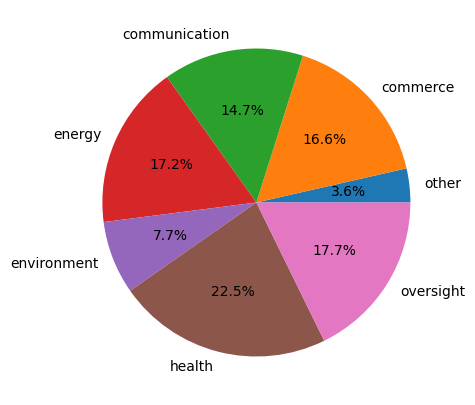

In [38]:
temp.plot(kind='pie',y='hearing_num', autopct='%1.1f%%', ylabel='', legend=False, figsize=(8,5))
# plt.title('Energy and Commerce Committee Composition', loc='center')

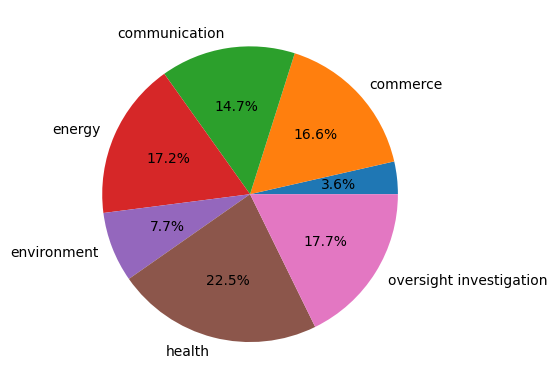

In [20]:
ax = transcripts_df.groupby(by=['subcom_corpus'])['hearing_num'].count().plot(kind='pie',y='hearing_num', autopct='%1.1f%%', ylabel='', title='Energy and Commerce Committee Composition')

In [85]:
ref_df = transcripts_df[['date','hearing_num','subcom_corpus','title','content']]
ref_df.to_csv('energy_commerce_all_trans.csv')

##### Subcoms - oil (non-renewable) related word count

In [121]:
oil_keywords = ['oil', 'gas', 'petroleum', 'hydrocarbon', 'hydrocarbons', 'unrenewable', 'coal', 'energy', 'exhaustible', 'shale', 'unconventionals', 'oilfields', 'minerals', 'bitumens', 'deepwaters', 'fuel', 'gasoline', 'depletable', 'mineral', 'petro', 'reinjection', 'uranium', 'synfuels', 'bitumen', 'extractive', 'Oil', 'liquifying', 'geothermic', 'oilfield', 'geothermal', 'Petroleum', 'biogases', 'Hydrocarbon', 'Gas', 'kerogen', 'lpg', 'petroliferous', 'deepwater', 'asphaltene', 'noncarbon', 'Varanus', 'nonproducing', 'Urucu', 'oilwell', 'mazut', 'feedstock', 'Hydrocarbons', 'renewables', 'butanes', 'diesel', 'crude']
oil_keywords = '|'.join(oil_keywords).lower()
oil_keywords

'oil|gas|petroleum|hydrocarbon|hydrocarbons|unrenewable|coal|energy|exhaustible|shale|unconventionals|oilfields|minerals|bitumens|deepwaters|fuel|gasoline|depletable|mineral|petro|reinjection|uranium|synfuels|bitumen|extractive|oil|liquifying|geothermic|oilfield|geothermal|petroleum|biogases|hydrocarbon|gas|kerogen|lpg|petroliferous|deepwater|asphaltene|noncarbon|varanus|nonproducing|urucu|oilwell|mazut|feedstock|hydrocarbons|renewables|butanes|diesel|crude'

In [122]:
transcripts_df['content'] = transcripts_df['content'].str.lower()
transcripts_df['count_oil'] = transcripts_df['content'].str.count(r'oil|gas|petroleum|hydrocarbon|hydrocarbons|unrenewable|coal|energy|exhaustible|shale|unconventionals|oilfields|minerals|bitumens|deepwaters|fuel|gasoline|depletable|mineral|petro|reinjection|uranium|synfuels|bitumen|extractive|Oil|liquifying|geothermic|oilfield|geothermal|Petroleum|biogases|Hydrocarbon|Gas|kerogen|lpg|petroliferous|deepwater|asphaltene|noncarbon|Varanus|nonproducing|Urucu|oilwell|mazut|feedstock|Hydrocarbons|renewables|butanes|diesel|crude')
transcripts_df

date hearing_num                              subcommittee  \
0     2002-09-26     107-130  commerce, trade, and consumer protection   
1     2002-02-13      107-82                    energy and air quality   
2     2002-03-13     107-100                                    health   
3     2002-07-10     107-133       telecommunications and the internet   
4     2002-04-11     107-107       environment and hazardous materials   
...          ...         ...                                       ...   
1607  2019-05-08      116-31          consumer protection and commerce   
1608  2019-05-23      116-39          consumer protection and commerce   
1609  2019-04-02      116-20            environment and climate change   
1610  2019-10-16      116-69     communications and technology and the   
1611  2019-09-19      116-62              oversight and investigations   

                                                content  \
0      ted cruz, director, office of policy planning...   
1      robert mccullough, managing partner, mccullou...   
2      college of american pathologists\n    the col...   
3      laura walker, president and ceo, wnyc\n    th...   
4      paul d. schwartz, national policy coordinator...   
...                                                 ...   
1607   hon. greg walden, a representative in \n     ...   
1608   hon. robert e. latta, a representative in \n ...   
1609   hon. greg walden, a representative in \n     ...   
1610   hon. greg walden, a representative in \n     ...   
1611   hon. greg walden, a representative in \n     ...   

                                                  title  \
0     State Impediments to E-Commerce: Consumer Prot...   
1     The Effect of the Bankruptcy of Enron on the F...   
2     The 2003 Budget: A Review of the HHS Health Ca...   
3     Corporation for Public Broadcasting Oversight ...   
4               Drinking Water Needs and Infrastructure   
...                                                 ...   
1607  Oversight of the Federal Trade Commission: Str...   
1608  Summer Driving Dangers: Exploring Ways to Prot...   
1609  Lessons from Across the Nation: State and Loca...   
1610  Fostering a Healthier Internet to Protect Cons...   
1611  Protecting Unaccompanied Children: The Ongoing...   

                                                 corpus  Sentiment  \
0     state impediment e commerce consumer protectio...     0.0000   
1     effect bankruptcy enron functioning energy market     0.2732   
2                budget review hhs health care priority     0.4939   
3     corporation public broadcasting oversight look...     0.0000   
4                    drinking water need infrastructure     0.0000   
...                                                 ...        ...   
1607  oversight federal trade commission strengtheni...     0.4939   
1608  summer driving danger exploring way protect dr...    -0.1531   
1609  lesson across nation state local action combat...    -0.3400   
1610      fostering healthier internet protect consumer     0.3818   
1611  protecting unaccompanied child ongoing impact ...    -0.5859   

                subcom_corpus  count_oil  count_energy  
0                    commerce          1            10  
1                      energy         45           115  
2                      health          7             7  
3               communication         27            34  
4                 environment          3             9  
...                       ...        ...           ...  
1607                 commerce          4             9  
1608                 commerce          8            14  
1609              environment        273           540  
1610            communication          5            22  
1611  oversight investigation          0             2  

[1612 rows x 10 columns]

<Axes: title={'center': 'count_oil'}, xlabel='subcom_corpus'>

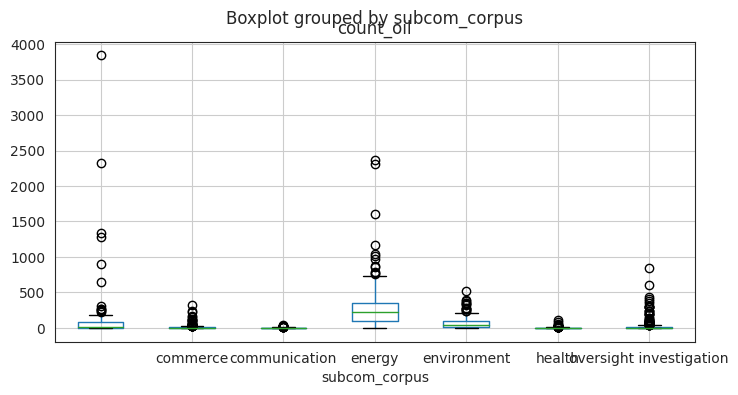

In [123]:
transcripts_df.boxplot(column=['count_oil'],by='subcom_corpus',figsize=(8,4))

In [124]:
transcripts_df.groupby(by=['subcom_corpus'])['count_oil'].describe().astype(int)

count  mean  std  min  25%  50%  75%   max
subcom_corpus                                                      
                            59   217  623    0    1    9   80  3843
commerce                   266    13   35    0    1    4   10   318
communication              237     4    6    0    1    3    6    48
energy                     275   277  287    1   96  220  358  2364
environment                123    77  100    1   11   35   99   518
health                     365     5    9    0    1    3    6   108
oversight investigation    287    33   91    0    1    3   16   840

In [125]:
transcripts_df[transcripts_df['count_oil'] == 3843]

date hearing_num subcommittee  \
707  2006-05-10      109-94                

                                               content  \
707  <html>\n<title> - gasoline: supply, price, and...   

                                           title  \
707  Gasoline: Supply, Price, and Specifications   

                                  corpus  Sentiment subcom_corpus  count_oil  \
707  gasoline supply price specification        0.0                     3843   

     count_energy  
707          3652

##### Subcoms - Energy-related word count

In [126]:
energy_keywords = ['electricity',
 'Energy',
 'renewables',
 'renewable',
 'noncarbon',
 'solar',
 'decarbonizing',
 'renewably',
 'gas',
 'unrenewable',
 'fuel',
 'decarbonising',
 'power',
 'efficiency',
 'photovoltaics',
 'geothermal',
 'electricy',
 'decarbonised',
 'ENERGY',
 'coal',
 'electric',
 'kwH',
 'decarbonisation',
 'biomass',
 'Renewable',
 'heating',
 'fuels',
 'petroleum',
 'oil',
 'electricty',
 'decarbonization',
 'decarbonized',
 'kWh',
 'photovoltaic',
 'hydropower',
 'exhaustible',
 'Renewables',
 'utilities',
 'hydroelectricity',
 'decarbonise',
 'KWh',
 'thermoelectricity',
 'decarbonize',
 'ethanols',
 'desalinization',
 'geothermic',
 'megawatts',
 'wind',
 'biogases',
 'Geothermal',
 'carbon']
energy_keywords = '|'.join(energy_keywords).lower()
energy_keywords

'electricity|energy|renewables|renewable|noncarbon|solar|decarbonizing|renewably|gas|unrenewable|fuel|decarbonising|power|efficiency|photovoltaics|geothermal|electricy|decarbonised|energy|coal|electric|kwh|decarbonisation|biomass|renewable|heating|fuels|petroleum|oil|electricty|decarbonization|decarbonized|kwh|photovoltaic|hydropower|exhaustible|renewables|utilities|hydroelectricity|decarbonise|kwh|thermoelectricity|decarbonize|ethanols|desalinization|geothermic|megawatts|wind|biogases|geothermal|carbon'

In [127]:
transcripts_df['count_energy'] = transcripts_df['content'].str.count(r'electricity|energy|renewables|renewable|noncarbon|solar|decarbonizing|renewably|gas|unrenewable|fuel|decarbonising|power|efficiency|photovoltaics|geothermal|electricy|decarbonised|energy|coal|electric|kwh|decarbonisation|biomass|renewable|heating|fuels|petroleum|oil|electricty|decarbonization|decarbonized|kwh|photovoltaic|hydropower|exhaustible|renewables|utilities|hydroelectricity|decarbonise|kwh|thermoelectricity|decarbonize|ethanols|desalinization|geothermic|megawatts|wind|biogases|geothermal|carbon')
transcripts_df

date hearing_num                              subcommittee  \
0     2002-09-26     107-130  commerce, trade, and consumer protection   
1     2002-02-13      107-82                    energy and air quality   
2     2002-03-13     107-100                                    health   
3     2002-07-10     107-133       telecommunications and the internet   
4     2002-04-11     107-107       environment and hazardous materials   
...          ...         ...                                       ...   
1607  2019-05-08      116-31          consumer protection and commerce   
1608  2019-05-23      116-39          consumer protection and commerce   
1609  2019-04-02      116-20            environment and climate change   
1610  2019-10-16      116-69     communications and technology and the   
1611  2019-09-19      116-62              oversight and investigations   

                                                content  \
0      ted cruz, director, office of policy planning...   
1      robert mccullough, managing partner, mccullou...   
2      college of american pathologists\n    the col...   
3      laura walker, president and ceo, wnyc\n    th...   
4      paul d. schwartz, national policy coordinator...   
...                                                 ...   
1607   hon. greg walden, a representative in \n     ...   
1608   hon. robert e. latta, a representative in \n ...   
1609   hon. greg walden, a representative in \n     ...   
1610   hon. greg walden, a representative in \n     ...   
1611   hon. greg walden, a representative in \n     ...   

                                                  title  \
0     State Impediments to E-Commerce: Consumer Prot...   
1     The Effect of the Bankruptcy of Enron on the F...   
2     The 2003 Budget: A Review of the HHS Health Ca...   
3     Corporation for Public Broadcasting Oversight ...   
4               Drinking Water Needs and Infrastructure   
...                                                 ...   
1607  Oversight of the Federal Trade Commission: Str...   
1608  Summer Driving Dangers: Exploring Ways to Prot...   
1609  Lessons from Across the Nation: State and Loca...   
1610  Fostering a Healthier Internet to Protect Cons...   
1611  Protecting Unaccompanied Children: The Ongoing...   

                                                 corpus  Sentiment  \
0     state impediment e commerce consumer protectio...     0.0000   
1     effect bankruptcy enron functioning energy market     0.2732   
2                budget review hhs health care priority     0.4939   
3     corporation public broadcasting oversight look...     0.0000   
4                    drinking water need infrastructure     0.0000   
...                                                 ...        ...   
1607  oversight federal trade commission strengtheni...     0.4939   
1608  summer driving danger exploring way protect dr...    -0.1531   
1609  lesson across nation state local action combat...    -0.3400   
1610      fostering healthier internet protect consumer     0.3818   
1611  protecting unaccompanied child ongoing impact ...    -0.5859   

                subcom_corpus  count_oil  count_energy  
0                    commerce          1            10  
1                      energy         45           115  
2                      health          7             7  
3               communication         27            34  
4                 environment          3             9  
...                       ...        ...           ...  
1607                 commerce          4             9  
1608                 commerce          8            14  
1609              environment        273           540  
1610            communication          5            22  
1611  oversight investigation          0             2  

[1612 rows x 10 columns]

<Axes: title={'center': 'count_energy'}, xlabel='subcom_corpus'>

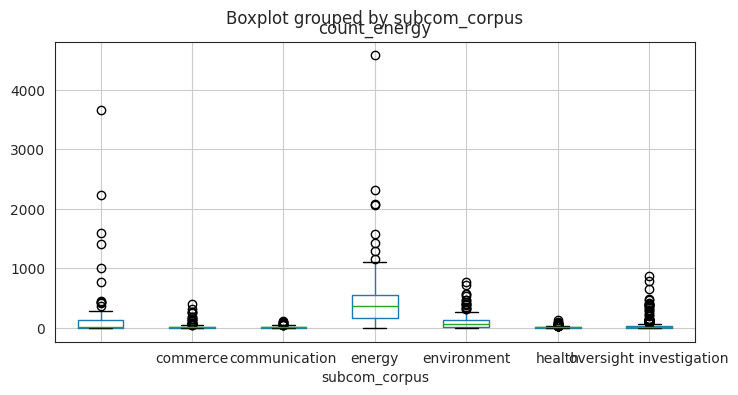

In [128]:
transcripts_df.boxplot(column=['count_energy'],by='subcom_corpus',figsize=(8,4))

##### Subcoms - Clean-related word count

In [129]:
clean_keywords = ['energy', 'clean', 'cleaner', 'decarbonizing', 'renewable', 'noncarbon', 'Clean', 'electricity', 'electricy', 'biogases', 'decarbonising', 'decarbonise', 'renewably', 'renewables', 'nonpolluting', 'decarbonized', 'decarbonised', 'Renewable', 'coal', 'decarbonize', 'efficiency', 'greening', 'thermoelectricity', 'green', 'desalinization', 'electrolyze', 'efficient', 'Energy', 'heating', 'greener', 'solar', 'fuel', 'weatherize', 'utilities', 'ethanols', 'fuels', 'biomass', 'unrenewable', 'polluting', 'environmentally', 'waste', 'digestor', 'decarbonisation', 'Renewables', 'conserve', 'carbon', 'BtL', 'water', 'conserving', 'decarbonization', 'solarize']
clean_keywords = '|'.join(clean_keywords).lower()
clean_keywords

'energy|clean|cleaner|decarbonizing|renewable|noncarbon|clean|electricity|electricy|biogases|decarbonising|decarbonise|renewably|renewables|nonpolluting|decarbonized|decarbonised|renewable|coal|decarbonize|efficiency|greening|thermoelectricity|green|desalinization|electrolyze|efficient|energy|heating|greener|solar|fuel|weatherize|utilities|ethanols|fuels|biomass|unrenewable|polluting|environmentally|waste|digestor|decarbonisation|renewables|conserve|carbon|btl|water|conserving|decarbonization|solarize'

In [130]:
transcripts_df['count_clean'] = transcripts_df['content'].str.count(r'energy|clean|cleaner|decarbonizing|renewable|noncarbon|clean|electricity|electricy|biogases|decarbonising|decarbonise|renewably|renewables|nonpolluting|decarbonized|decarbonised|renewable|coal|decarbonize|efficiency|greening|thermoelectricity|green|desalinization|electrolyze|efficient|energy|heating|greener|solar|fuel|weatherize|utilities|ethanols|fuels|biomass|unrenewable|polluting|environmentally|waste|digestor|decarbonisation|renewables|conserve|carbon|btl|water|conserving|decarbonization|solarize')
transcripts_df

date hearing_num                              subcommittee  \
0     2002-09-26     107-130  commerce, trade, and consumer protection   
1     2002-02-13      107-82                    energy and air quality   
2     2002-03-13     107-100                                    health   
3     2002-07-10     107-133       telecommunications and the internet   
4     2002-04-11     107-107       environment and hazardous materials   
...          ...         ...                                       ...   
1607  2019-05-08      116-31          consumer protection and commerce   
1608  2019-05-23      116-39          consumer protection and commerce   
1609  2019-04-02      116-20            environment and climate change   
1610  2019-10-16      116-69     communications and technology and the   
1611  2019-09-19      116-62              oversight and investigations   

                                                content  \
0      ted cruz, director, office of policy planning...   
1      robert mccullough, managing partner, mccullou...   
2      college of american pathologists\n    the col...   
3      laura walker, president and ceo, wnyc\n    th...   
4      paul d. schwartz, national policy coordinator...   
...                                                 ...   
1607   hon. greg walden, a representative in \n     ...   
1608   hon. robert e. latta, a representative in \n ...   
1609   hon. greg walden, a representative in \n     ...   
1610   hon. greg walden, a representative in \n     ...   
1611   hon. greg walden, a representative in \n     ...   

                                                  title  \
0     State Impediments to E-Commerce: Consumer Prot...   
1     The Effect of the Bankruptcy of Enron on the F...   
2     The 2003 Budget: A Review of the HHS Health Ca...   
3     Corporation for Public Broadcasting Oversight ...   
4               Drinking Water Needs and Infrastructure   
...                                                 ...   
1607  Oversight of the Federal Trade Commission: Str...   
1608  Summer Driving Dangers: Exploring Ways to Prot...   
1609  Lessons from Across the Nation: State and Loca...   
1610  Fostering a Healthier Internet to Protect Cons...   
1611  Protecting Unaccompanied Children: The Ongoing...   

                                                 corpus  Sentiment  \
0     state impediment e commerce consumer protectio...     0.0000   
1     effect bankruptcy enron functioning energy market     0.2732   
2                budget review hhs health care priority     0.4939   
3     corporation public broadcasting oversight look...     0.0000   
4                    drinking water need infrastructure     0.0000   
...                                                 ...        ...   
1607  oversight federal trade commission strengtheni...     0.4939   
1608  summer driving danger exploring way protect dr...    -0.1531   
1609  lesson across nation state local action combat...    -0.3400   
1610      fostering healthier internet protect consumer     0.3818   
1611  protecting unaccompanied child ongoing impact ...    -0.5859   

                subcom_corpus  count_oil  count_energy  count_clean  
0                    commerce          1            10            2  
1                      energy         45           115           66  
2                      health          7             7            7  
3               communication         27            34           46  
4                 environment          3             9          191  
...                       ...        ...           ...          ...  
1607                 commerce          4             9            6  
1608                 commerce          8            14           10  
1609              environment        273           540          513  
1610            communication          5            22           12  
1611  oversight investigation          0             2            9  

[1612 rows x 11 columns

<Axes: title={'center': 'count_clean'}, xlabel='subcom_corpus'>

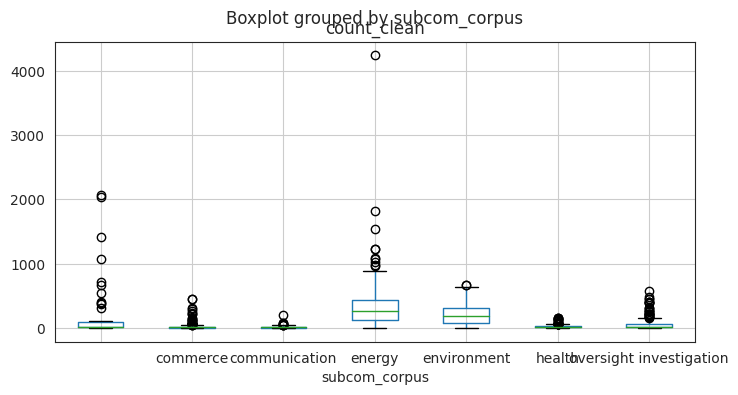

In [131]:
transcripts_df.boxplot(column=['count_clean'],by='subcom_corpus',figsize=(8,4))

##### Energy-related word count vs VDE trend

In [150]:
selected_df = transcripts_df[transcripts_df['subcom_corpus'].isin(['energy','','oversight investigation','environment'])]
selected_df['date'] = pd.to_datetime(selected_df['date'])
selected_df['content_length'] = selected_df['content'].str.len()
selected_df['ratio_oil'] = selected_df['count_oil']*10000/selected_df['content_length']
selected_df['ratio_energy'] = selected_df['count_energy']*10000/selected_df['content_length']
selected_df['ratio_clean'] = selected_df['count_clean']*10000/selected_df['content_length']
selected_df

/tmp/ipykernel_459128/197341198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['date'] = pd.to_datetime(selected_df['date'])
/tmp/ipykernel_459128/197341198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['content_length'] = selected_df['content'].str.len()
/tmp/ipykernel_459128/197341198.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

date hearing_num                         subcommittee  \
1    2002-02-13      107-82               energy and air quality   
4    2002-04-11     107-107  environment and hazardous materials   
8    2001-05-01      107-26               energy and air quality   
9    2001-06-07      107-30         oversight and investigations   
11   2001-10-10      107-64               energy and air quality   
...         ...         ...                                  ...   
1603 2019-04-02      116-21         oversight and investigations   
1604 2019-07-16      116-53         oversight and investigations   
1606 2019-10-30      116-77                               energy   
1609 2019-04-02      116-20       environment and climate change   
1611 2019-09-19      116-62         oversight and investigations   

                                                content  \
1      robert mccullough, managing partner, mccullou...   
4      paul d. schwartz, national policy coordinator...   
8     <html>\n<title> - the electricity emergency ac...   
9      donald dekieffer, dekieffer & horgan\n       ...   
11     michael j. travieso, maryland people's counse...   
...                                                 ...   
1603   hon. greg walden, a representative in \n     ...   
1604   hon. greg walden, a representative in \n     ...   
1606   hon. greg walden, a representative in \n     ...   
1609   hon. greg walden, a representative in \n     ...   
1611   hon. greg walden, a representative in \n     ...   

                                                  title  \
1     The Effect of the Bankruptcy of Enron on the F...   
4               Drinking Water Needs and Infrastructure   
8     The Electricity Emergency Act of 2001 Hearings...   
9     Continuing Concerns over Imported Pharmaceuticals   
11    Electric Transmission Policy: Regional Transmi...   
...                                                 ...   
1603  Priced out of a Lifesaving Drug: The Human Imp...   
1604  Oversight of Federal Efforts to Combat the Spr...   
1606  Building a 100 Percent Clean Economy: Solution...   
1609  Lessons from Across the Nation: State and Loca...   
1611  Protecting Unaccompanied Children: The Ongoing...   

                                                 corpus  Sentiment  \
1     effect bankruptcy enron functioning energy market     0.2732   
4                    drinking water need infrastructure     0.0000   
8     electricity emergency act hearing subcommittee...    -0.1280   
9            continuing concern imported pharmaceutical     0.0000   
11    electric transmission policy regional transmis...     0.0000   
...                                                 ...        ...   
1603  priced lifesaving drug human impact rising ins...     0.0000   
1604  oversight federal effort combat spread illicit...    -0.3400   
1606  building percent clean economy solution u powe...     0.5267   
1609  lesson across nation state local action combat...    -0.3400   
1611  protecting unaccompanied child ongoing impact ...    -0.5859   

                subcom_corpus  count_oil  count_energy  count_clean  \
1                      energy         45           115           66   
4                 environment          3             9          191   
8                      energy          5             7            7   
9     oversight investigation          0             4           18   
11                     energy         14            94           37   
...                       ...        ...           ...          ...   
1603  oversight investigation          5            31            7   
1604  oversight investigation          0             2            4   
1606                   energy        231           612          511   
1609              environment        273           540          513   
1611  oversight investigation          0             2            9   

      content_length  ratio_oil  ratio_energy  ratio_clean  
1              66514 

In [ ]:
# Word cloud-Senate Hearing on Hearing and Commerce Hearings
from wordcloud import WordCloud

comments = selected_df['content']
all_comments = ' '.join(comments)
processed_comments = preprocess_text(all_comments)
fdist = FreqDist(processed_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud - Senate Hearing on Oversight of AI')
plt.show()

In [3]:
import pandas as pd
import numpy as np

# VDE price
vde_price = pd.read_csv('/home/congress-user/data_collection/EDA/supp_data/VDE.csv',on_bad_lines='skip')
vde_price['Date'] = pd.to_datetime(vde_price['Date'])
vde_price['month'] = vde_price['Date'].dt.to_period('M')
# vde_price = vde_price[(vde_price['Date'] > '2010-01-01') & (vde_price['Date'] < '2022-01-01')]
vde_price = vde_price[['Date','month','Close','Volume']]
vde_price['Log_Ret'] = np.log(vde_price['Close'] / vde_price['Close'].shift(1))
vde_price['Volatility'] = vde_price['Log_Ret'].rolling(window=30).std() * np.sqrt(252)
vde_price = vde_price.dropna()
vde_price

Date    month       Close  Volume   Log_Ret  Volatility
30   2004-11-10  2004-11   50.849998    6800  0.011870    0.202824
31   2004-11-11  2004-11   50.840000    1800 -0.000197    0.201266
32   2004-11-12  2004-11   51.799999   14300  0.018707    0.205145
33   2004-11-15  2004-11   50.599998    5700 -0.023439    0.216513
34   2004-11-16  2004-11   50.750000    3200  0.002960    0.214892
...         ...      ...         ...     ...       ...         ...
4773 2023-09-15  2023-09  128.889999  464700 -0.012567    0.162014
4774 2023-09-18  2023-09  129.630005  506600  0.005725    0.162359
4775 2023-09-19  2023-09  128.449997  361300 -0.009145    0.165620
4776 2023-09-20  2023-09  127.290001  792200 -0.009072    0.168082
4777 2023-09-21  2023-09  125.449997  684900 -0.014561    0.170562

[4748 rows x 6 columns]

<Axes: xlabel='Date'>

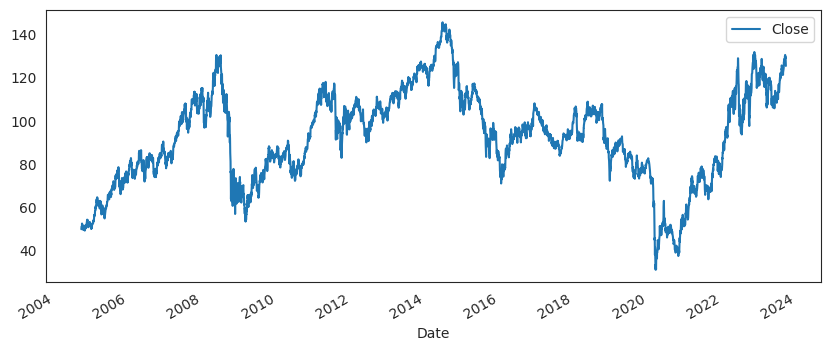

In [140]:
vde_price.plot(x='Date',y='Close', figsize=(10,4))

<Axes: xlabel='Date'>

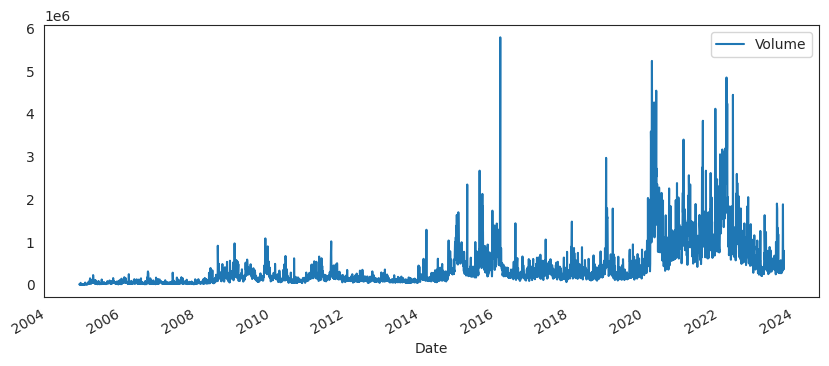

In [180]:
vde_price.plot(x='Date',y='Volume', figsize=(10,4))

<Axes: xlabel='Date'>

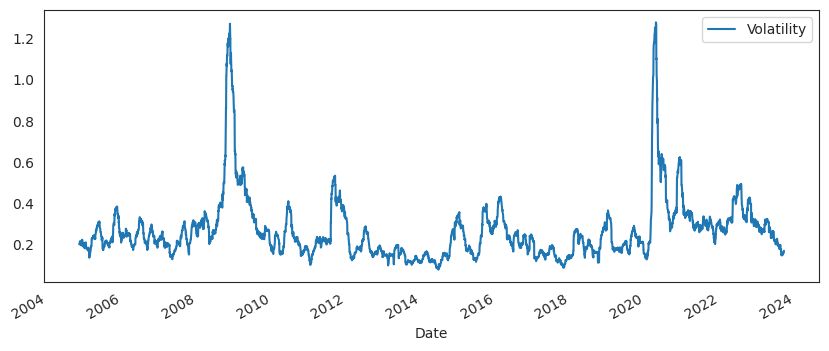

In [169]:
vde_price[(vde_price['Date'] >= '2018-01-01') & (vde_price['Date'] <= '2018-12-31')].plot(x='Date',y='Volatility', figsize=(10,4))

In [170]:
vde_trans = vde_price.merge(selected_df[['date','Sentiment','ratio_energy','ratio_oil','ratio_clean','hearing_num']],left_on='Date',right_on='date')
vde_trans

Date    month      Close   Volume   Log_Ret  Volatility       date  \
0   2004-12-07  2004-12  50.889999     5100 -0.015985    0.224060 2004-12-07   
1   2005-01-26  2005-01  53.630001     7800  0.008990    0.176072 2005-01-26   
2   2005-02-09  2005-02  56.439999    23000 -0.004243    0.167834 2005-02-09   
3   2005-02-10  2005-02  57.900002    18600  0.025539    0.180309 2005-02-10   
4   2005-02-17  2005-02  59.509998    73700 -0.012358    0.153548 2005-02-17   
..         ...      ...        ...      ...       ...         ...        ...   
628 2021-05-25  2021-05  71.779999   772800 -0.020682    0.305796 2021-05-25   
629 2021-05-26  2021-05  72.540001   548000  0.010532    0.295321 2021-05-26   
630 2021-06-09  2021-06  78.059998   741800 -0.005239    0.294637 2021-06-09   
631 2021-06-29  2021-06  74.900002  1041000 -0.005326    0.280610 2021-06-29   
632 2021-07-27  2021-07  69.099998  1300700 -0.012369    0.337523 2021-07-27   

     Sentiment  ratio_energy  ratio_oil  ratio_clean hearing_num  
0       0.0000      0.123687   0.123687     1.607936     108-126  
1       0.0000      1.014816   0.000000     1.014816      109-10  
2       0.2732     29.117980  24.127399    25.328140       109-3  
3       0.2732     27.757446  16.665728    28.545690       109-1  
4       0.4939      1.092633   0.072842     0.509896      109-35  
..         ...           ...        ...          ...         ...  
628     0.8720      5.247447   3.010830    38.538629      117-34  
629     0.5106      0.557394   0.348371     0.627068      117-35  
630     0.0000      0.746609   0.373304     0.671948      117-37  
631     0.6597     35.363990  14.934902    29.289431      117-40  
632     0.2732     30.687521  15.691955    20.195267      117-45  

[633 rows x 12 columns]

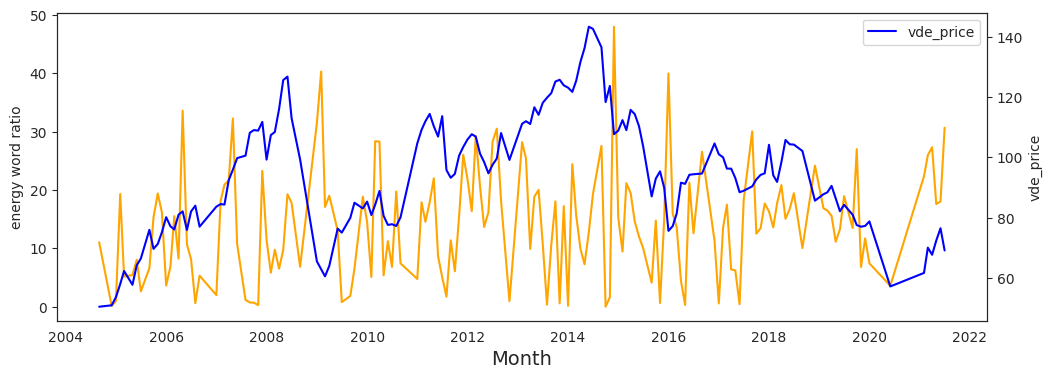

In [153]:
# energy-related word ratio vs vde price
vd_energy = vde_trans.copy()
vd_energy = vd_energy.groupby(by=['month'])[['Close','ratio_energy']].mean().reset_index()
vd_energy['month'] = vd_energy['month'].dt.to_timestamp()
# # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(vd_energy['month'], vd_energy['ratio_energy'], color='orange',label='energy word ratio')
ax1.set_ylabel('energy word ratio')

ax2 = ax1.twinx()
ax2.plot(vd_energy['month'], vd_energy['Close'], color='blue',label='vde_price')
ax2.set_ylabel('vde_price')

ax1.set_xlabel('Month', fontsize=14)
# ax1.set_title('Revenue and Sales by Product', fontsize=16)

plt.legend()
plt.show()

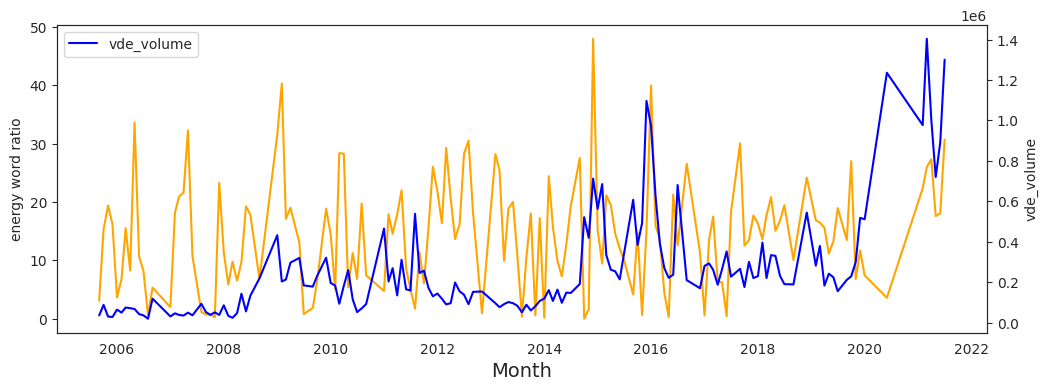

In [163]:
# energy-related word ratio vs vde volume
vd_energy = vde_trans.copy()
vd_energy = vd_energy.groupby(by=['month'])[['Volume','ratio_energy']].mean().reset_index()
vd_energy['month'] = vd_energy['month'].dt.to_timestamp()
# # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(vd_energy['month'], vd_energy['ratio_energy'], color='orange',label='energy word ratio')
ax1.set_ylabel('energy word ratio')

ax2 = ax1.twinx()
ax2.plot(vd_energy['month'], vd_energy['Volume'], color='blue',label='vde_volume')
ax2.set_ylabel('vde_volume')

ax1.set_xlabel('Month', fontsize=14)
# ax1.set_title('Revenue and Sales by Product', fontsize=16)

plt.legend()
plt.show()

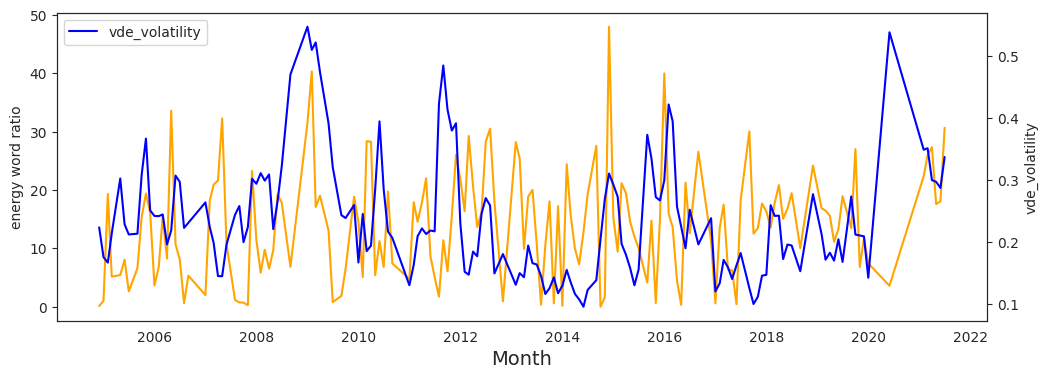

In [171]:
# energy-related word ratio vs vde volatility
vd_energy = vde_trans.copy()
vd_energy = vd_energy.groupby(by=['month'])[['Volatility','ratio_energy']].mean().reset_index()
vd_energy['month'] = vd_energy['month'].dt.to_timestamp()
# # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(vd_energy['month'], vd_energy['ratio_energy'], color='orange',label='energy word ratio')
ax1.set_ylabel('energy word ratio')

ax2 = ax1.twinx()
ax2.plot(vd_energy['month'], vd_energy['Volatility'], color='blue',label='vde_volatility')
ax2.set_ylabel('vde_volatility')

ax1.set_xlabel('Month', fontsize=14)
# ax1.set_title('Revenue and Sales by Product', fontsize=16)

plt.legend()
plt.show()

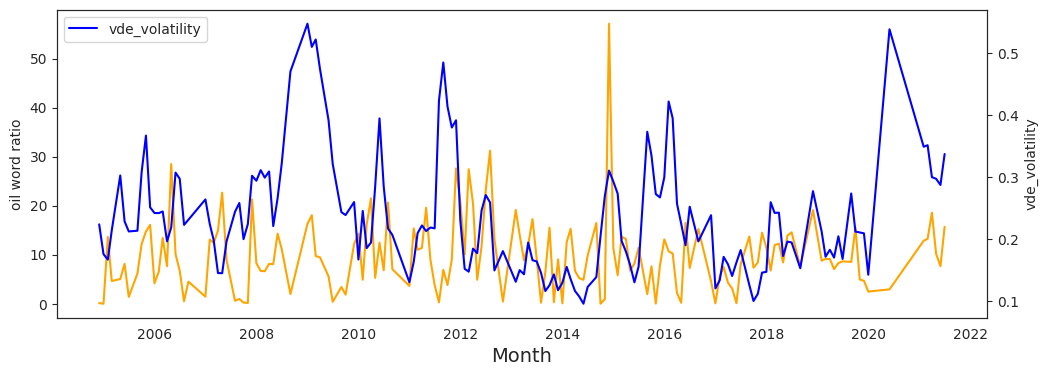

In [173]:
# energy-related word ratio vs vde volatility
vd_energy = vde_trans.copy()
vd_energy = vd_energy.groupby(by=['month'])[['Volatility','ratio_oil']].mean().reset_index()
vd_energy['month'] = vd_energy['month'].dt.to_timestamp()
# # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(vd_energy['month'], vd_energy['ratio_oil'], color='orange',label='oil word ratio')
ax1.set_ylabel('oil word ratio')

ax2 = ax1.twinx()
ax2.plot(vd_energy['month'], vd_energy['Volatility'], color='blue',label='vde_volatility')
ax2.set_ylabel('vde_volatility')

ax1.set_xlabel('Month', fontsize=14)
# ax1.set_title('Revenue and Sales by Product', fontsize=16)

plt.legend()
plt.show()

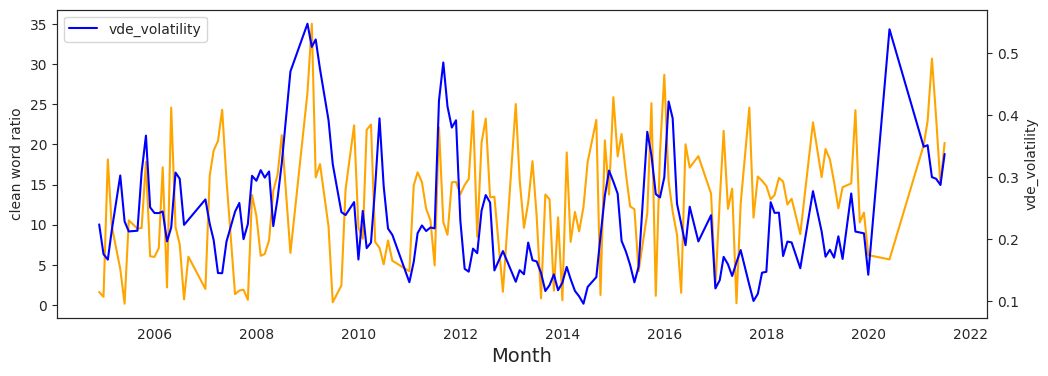

In [175]:
# energy-related word ratio vs vde volatility
vd_energy = vde_trans.copy()
vd_energy = vd_energy.groupby(by=['month'])[['Volatility','ratio_clean']].mean().reset_index()
vd_energy['month'] = vd_energy['month'].dt.to_timestamp()
# # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(vd_energy['month'], vd_energy['ratio_clean'], color='orange',label='clean word ratio')
ax1.set_ylabel('clean word ratio')

ax2 = ax1.twinx()
ax2.plot(vd_energy['month'], vd_energy['Volatility'], color='blue',label='vde_volatility')
ax2.set_ylabel('vde_volatility')

ax1.set_xlabel('Month', fontsize=14)
# ax1.set_title('Revenue and Sales by Product', fontsize=16)

plt.legend()
plt.show()

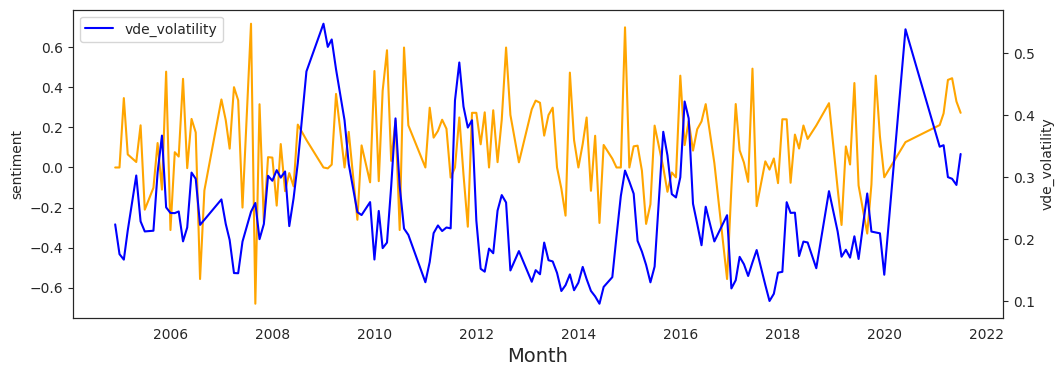

In [178]:
# energy-related word ratio vs vde volatility
vd_energy = vde_trans.copy()
vd_energy = vd_energy.groupby(by=['month'])[['Volatility','Sentiment']].mean().reset_index()
vd_energy['month'] = vd_energy['month'].dt.to_timestamp()
# # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(vd_energy['month'], vd_energy['Sentiment'], color='orange',label='sentiment')
ax1.set_ylabel('sentiment')

ax2 = ax1.twinx()
ax2.plot(vd_energy['month'], vd_energy['Volatility'], color='blue',label='vde_volatility')
ax2.set_ylabel('vde_volatility')

ax1.set_xlabel('Month', fontsize=14)
# ax1.set_title('Revenue and Sales by Product', fontsize=16)

plt.legend()
plt.show()

In [172]:
vde_trans

Date    month      Close   Volume   Log_Ret  Volatility       date  \
0   2004-12-07  2004-12  50.889999     5100 -0.015985    0.224060 2004-12-07   
1   2005-01-26  2005-01  53.630001     7800  0.008990    0.176072 2005-01-26   
2   2005-02-09  2005-02  56.439999    23000 -0.004243    0.167834 2005-02-09   
3   2005-02-10  2005-02  57.900002    18600  0.025539    0.180309 2005-02-10   
4   2005-02-17  2005-02  59.509998    73700 -0.012358    0.153548 2005-02-17   
..         ...      ...        ...      ...       ...         ...        ...   
628 2021-05-25  2021-05  71.779999   772800 -0.020682    0.305796 2021-05-25   
629 2021-05-26  2021-05  72.540001   548000  0.010532    0.295321 2021-05-26   
630 2021-06-09  2021-06  78.059998   741800 -0.005239    0.294637 2021-06-09   
631 2021-06-29  2021-06  74.900002  1041000 -0.005326    0.280610 2021-06-29   
632 2021-07-27  2021-07  69.099998  1300700 -0.012369    0.337523 2021-07-27   

     Sentiment  ratio_energy  ratio_oil  ratio_clean hearing_num  
0       0.0000      0.123687   0.123687     1.607936     108-126  
1       0.0000      1.014816   0.000000     1.014816      109-10  
2       0.2732     29.117980  24.127399    25.328140       109-3  
3       0.2732     27.757446  16.665728    28.545690       109-1  
4       0.4939      1.092633   0.072842     0.509896      109-35  
..         ...           ...        ...          ...         ...  
628     0.8720      5.247447   3.010830    38.538629      117-34  
629     0.5106      0.557394   0.348371     0.627068      117-35  
630     0.0000      0.746609   0.373304     0.671948      117-37  
631     0.6597     35.363990  14.934902    29.289431      117-40  
632     0.2732     30.687521  15.691955    20.195267      117-45  

[633 rows x 12 columns]

#### Read Full File

In [3]:
file = open('/home/congress-user/data_collection/transcripts/118/2023-02-01_118-2.txt','r')
lines = [re.subn(r'[^A-Za-z0-9 ]+','',line.strip())[0].split(' ') for line in file.readlines() if line.strip()]
words = [item for sublist in lines for item in sublist]
words

['html',
 'title',
 '',
 'LIVES',
 'WORTH',
 'LIVING',
 'ADDRESSING',
 'THE',
 'FENTANYL',
 'CRISIS',
 'PROTECTING',
 'CRITICAL',
 'LIFELINES',
 'AND',
 'COMBATING',
 'DISCRIMINATION',
 'AGAINST',
 'THOSE',
 'WITH',
 'DISABILITIEStitle',
 'bodypre',
 'House',
 'Hearing',
 '118',
 'Congress',
 'From',
 'the',
 'US',
 'Government',
 'Publishing',
 'Office',
 'LIVES',
 'WORTH',
 'LIVING',
 'ADDRESSING',
 'THE',
 'FENTANYL',
 'CRISIS',
 'PROTECTING',
 'CRITICAL',
 'LIFE',
 'LINES',
 'AND',
 'COMBATING',
 'DISCRIMINATION',
 'AGAINST',
 'THOSE',
 'WITH',
 'DISABILITIES',
 '',
 'HEARING',
 'BEFORE',
 'THE',
 'SUBCOMMITTEE',
 'ON',
 'HEALTH',
 'OF',
 'THE',
 'COMMITTEE',
 'ON',
 'ENERGY',
 'AND',
 'COMMERCE',
 'HOUSE',
 'OF',
 'REPRESENTATIVES',
 'ONE',
 'HUNDRED',
 'EIGHTEENTH',
 'CONGRESS',
 'FIRST',
 'SESSION',
 '',
 'FEBRUARY',
 '1',
 '2023',
 '',
 'Serial',
 'No',
 '1182',
 'GRAPHIC',
 'NOT',
 'AVAILABLE',
 'IN',
 'TIFF',
 'FORMAT',
 'Published',
 'for',
 'the',
 'use',
 'of',
 'the',
 'C

In [40]:
# reading txt files into dataframe of words
transcripts_dir = '/home/congress-user/data_collection/transcripts'
transcripts_df = pd.DataFrame(columns=['date','hearing_num','words'])

for subdir, dirs, files in os.walk(transcripts_dir):
    for file in files:
        date, hearing_num = str(file).split('.')[0].split('_')
        file_path = os.path.join(subdir,file)
        file = open(file_path,'r')
        lines = [re.subn(r'[^A-Za-z0-9 ]+','',line.strip())[0].split(' ') for line in file.readlines() if line.strip()]
        words = [item for sublist in lines for item in sublist]
        transcripts_df.loc[len(transcripts_df.index)] = [date, hearing_num, words]     

transcripts_df

date hearing_num  \
0     2002-09-26     107-130   
1     2002-02-13      107-82   
2     2002-03-13     107-100   
3     2002-07-10     107-133   
4     2002-04-11     107-107   
...          ...         ...   
1599  2019-05-23      116-39   
1600  2019-04-02      116-20   
1601  2019-10-16      116-69   
1602  2019-09-19      116-62   
1603  1993-07-01      103-35   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    words  
0                                                                   [html, title, , STATE, IMPEDIMENTS, TO, ECOMMERCE, CONSUMER, PROTECTION, OR, VEILED, PROTECTIONISMtitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, STATE, IMPEDIMENTS, TO, ECOMMERCE, CONSUMER, PROTECTION, OR, VEILED, PROTECTIONISM, , HEARING, before, the, SUBCOMMITTEE, ON, COMMERCE, TRADE, AND, CONSUMER, PROTECTION, of, the, COMMITTEE, ON, ENERGY, AND, COMMERCE, HOUSE, OF, REPRESENTATIVES, ONE, HUNDRED, SEVENTH, CONGRESS, SECOND, SESSION, , SEPTEMBER, 26, 2002, , Serial, No, 107130, , Printed, for, the, use, of, the, Committee, on, Energy, and, Commerce, Available, via, the, World, Wide, Web, httpwwwaccessgpogovcongress, house, , US, GOVERNMENT, PRINTING, OFFICE, 81963, , , , , , , , ...]  
1                                                                                            [html, title, , THE, EFFECT, OF, THE, BANKRUPTCY, OF, ENRON, ON, THE, FUNCTIONING, OF, ENERGY, MARKETStitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, THE, EFFECT, OF, THE, BANKRUPTCY, OF, ENRON, ON, THE, FUNCTIONING, OF, ENERGY, MARKETS, , HEARING, before, the, SUBCOMMITTEE, ON, ENERGY, AND, AIR, QUALITY, of, the, COMMITTEE, ON, ENERGY, AND, COMMERCE, HOUSE, OF, REPRESENTATIVES, ONE, HUNDRED, SEVENTH, CONGRESS, SECOND, SESSION, , FEBRUARY, 13, 2002, , Serial, No, 10782, , Printed, for, the, use, of, the, Committee, on, Energy, and, Commerce, Available, via, the, World, Wide, Web, httpwwwaccessgpogovcongress, house, US, GOVERNMENT, PRINTING, OFFICE, 77988, , ...]  
2                                                                                                                                                                 [html, title, , THE, 2003, BUDGET, A, REVIEW, OF, THE, HHS, HEALTH, CARE, PRIORITIEStitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, THE, 2003, BUDGET, A, REVIEW, OF, THE, HHS, HEALTH, CARE, PRIORITIES, , HEARING, before, the, SUBCOMMITTEE, ON, HEALTH, of, the, COMMITTEE, ON, ENERGY, AND, COMMERCE, HOUSE, OF, REPRESENTATIVES, ONE, HUNDRED, SEVENTH, CONGRESS, SECOND, SESSION, , MARCH, 13, 2002, , Serial, No, 107100, , Printed, for, the, use, of, the, Committee, on, Energy, and, Commerce, Available, via, the, World, Wide, Web, httpwwwaccessgpogovcongress, house, , 78504, , , , , , , , , , , , ...]  
3                                                               [html, title, , CORPORATION, FOR, PUBLIC, BROADCASTING, OVERSIGHT, AND, A, LOOK, INTO, PUBLIC, BROADCASTING, IN, THE, DIGITAL, ERAtitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, CORPORATION, FOR, PUBLIC, BROADCASTING, OVERSIGHT, AND, A, LOOK, INTO, PUBLIC, BROADCASTING

In [44]:
# data manipulation
transcripts_df['date'] = pd.to_datetime(transcripts_df['date'])
transcripts_df = transcripts_df[transcripts_df['date'] >= '2000-01-01']
transcripts_df

date hearing_num  \
0    2002-09-26     107-130   
1    2002-02-13      107-82   
2    2002-03-13     107-100   
3    2002-07-10     107-133   
4    2002-04-11     107-107   
...         ...         ...   
1598 2019-05-08      116-31   
1599 2019-05-23      116-39   
1600 2019-04-02      116-20   
1601 2019-10-16      116-69   
1602 2019-09-19      116-62   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       words  
0                                                                      [html, title, , STATE, IMPEDIMENTS, TO, ECOMMERCE, CONSUMER, PROTECTION, OR, VEILED, PROTECTIONISMtitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, STATE, IMPEDIMENTS, TO, ECOMMERCE, CONSUMER, PROTECTION, OR, VEILED, PROTECTIONISM, , HEARING, before, the, SUBCOMMITTEE, ON, COMMERCE, TRADE, AND, CONSUMER, PROTECTION, of, the, COMMITTEE, ON, ENERGY, AND, COMMERCE, HOUSE, OF, REPRESENTATIVES, ONE, HUNDRED, SEVENTH, CONGRESS, SECOND, SESSION, , SEPTEMBER, 26, 2002, , Serial, No, 107130, , Printed, for, the, use, of, the, Committee, on, Energy, and, Commerce, Available, via, the, World, Wide, Web, httpwwwaccessgpogovcongress, house, , US, GOVERNMENT, PRINTING, OFFICE, 81963, , , , , , , , ...]  
1                                                                                               [html, title, , THE, EFFECT, OF, THE, BANKRUPTCY, OF, ENRON, ON, THE, FUNCTIONING, OF, ENERGY, MARKETStitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, THE, EFFECT, OF, THE, BANKRUPTCY, OF, ENRON, ON, THE, FUNCTIONING, OF, ENERGY, MARKETS, , HEARING, before, the, SUBCOMMITTEE, ON, ENERGY, AND, AIR, QUALITY, of, the, COMMITTEE, ON, ENERGY, AND, COMMERCE, HOUSE, OF, REPRESENTATIVES, ONE, HUNDRED, SEVENTH, CONGRESS, SECOND, SESSION, , FEBRUARY, 13, 2002, , Serial, No, 10782, , Printed, for, the, use, of, the, Committee, on, Energy, and, Commerce, Available, via, the, World, Wide, Web, httpwwwaccessgpogovcongress, house, US, GOVERNMENT, PRINTING, OFFICE, 77988, , ...]  
2                                                                                                                                                                    [html, title, , THE, 2003, BUDGET, A, REVIEW, OF, THE, HHS, HEALTH, CARE, PRIORITIEStitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, THE, 2003, BUDGET, A, REVIEW, OF, THE, HHS, HEALTH, CARE, PRIORITIES, , HEARING, before, the, SUBCOMMITTEE, ON, HEALTH, of, the, COMMITTEE, ON, ENERGY, AND, COMMERCE, HOUSE, OF, REPRESENTATIVES, ONE, HUNDRED, SEVENTH, CONGRESS, SECOND, SESSION, , MARCH, 13, 2002, , Serial, No, 107100, , Printed, for, the, use, of, the, Committee, on, Energy, and, Commerce, Available, via, the, World, Wide, Web, httpwwwaccessgpogovcongress, house, , 78504, , , , , , , , , , , , ...]  
3                                                                  [html, title, , CORPORATION, FOR, PUBLIC, BROADCASTING, OVERSIGHT, AND, A, LOOK, INTO, PUBLIC, BROADCASTING, IN, THE, DIGITAL, ERAtitle, bodypre, House, Hearing, 107, Congress, From, the, US, Government, Publishing, Office, CORPORATION, FOR, PUBLIC, BROADCASTING, OVERSIGHT, AND, A, LOOK, INTO, PUBLIC, BROADCAS

In [45]:
# explode df
explode_df = transcripts_df.explode('words')
explode_df

date hearing_num        words
0    2002-09-26     107-130         html
0    2002-09-26     107-130        title
0    2002-09-26     107-130             
0    2002-09-26     107-130        STATE
0    2002-09-26     107-130  IMPEDIMENTS
...         ...         ...          ...
1602 2019-09-19      116-62           IN
1602 2019-09-19      116-62         TIFF
1602 2019-09-19      116-62       FORMAT
1602 2019-09-19      116-62          all
1602 2019-09-19      116-62  prebodyhtml

[56690950 rows x 3 columns]

Text(0.5, 1.0, 'hearing counts per year')

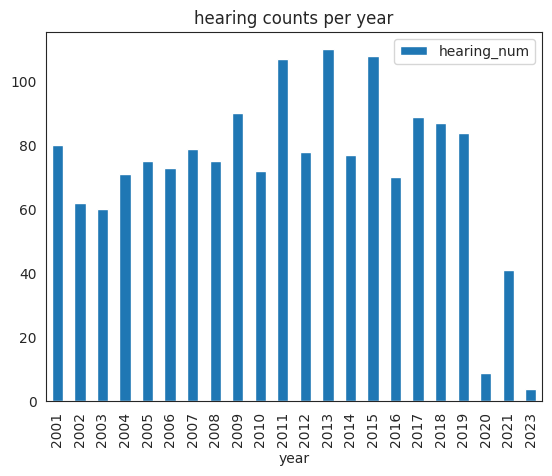

In [46]:
# number of hearings per year
transcripts_by_year = transcripts_df.copy()
transcripts_by_year['year'] = transcripts_by_year['date'].dt.year
transcripts_by_year = transcripts_by_year.groupby(by=['year'])['hearing_num'].count().reset_index()
transcripts_by_year.plot.bar(x='year',y='hearing_num')
plt.title('hearing counts per year')

In [47]:
# hearing word count
transcripts_word_count = explode_df.copy()
transcripts_word_count = transcripts_word_count.groupby(by=['date','hearing_num'])['words'].count().reset_index()
transcripts_word_count

date hearing_num   words
0    2001-02-08       107-4   69117
1    2001-02-14      107-25  112117
2    2001-02-15       107-1   54064
3    2001-02-15       107-7   86929
4    2001-02-28      107-11   81872
...         ...         ...     ...
1596 2021-07-29      117-47   50473
1597 2023-02-01       118-2   45479
1598 2023-02-01       118-3   25270
1599 2023-02-02       118-5   30750
1600 2023-02-08       118-8   45805

[1601 rows x 3 columns]

Text(0.5, 1.0, 'script length boxplot by year')

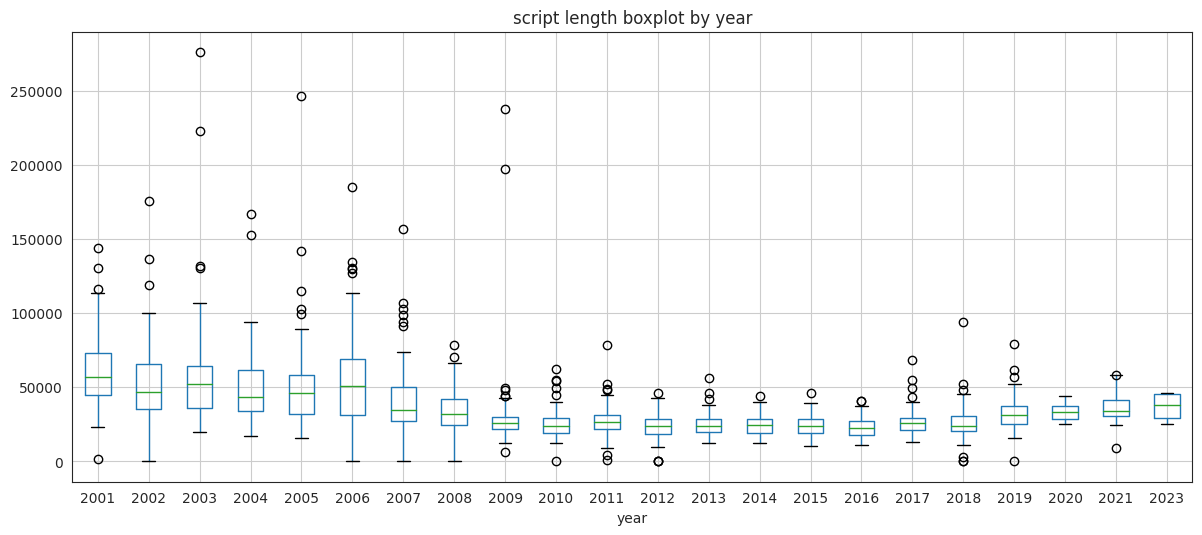

In [48]:
# word count by year
transcripts_word_count_by_year = transcripts_word_count.copy()
transcripts_word_count_by_year['year'] = transcripts_word_count_by_year['date'].dt.year
# year_groups = transcripts_word_count_by_year.groupby('year')
transcripts_word_count_by_year.boxplot(column=['words'],by='year',figsize=(14,6))
plt.suptitle('')
plt.title('script length boxplot by year')

In [53]:
# SNP data
snp_1 = pd.read_csv('/home/congress-user/data_collection/EDA/supp_data/HistoricalData_1695392615852.csv')
snp_2 = pd.read_csv('/home/congress-user/data_collection/EDA/supp_data/S&P 500 Historical Data.csv')

# snp_1: 2013.9.23 - 2023.9.21
snp_1 = snp_1[['Date','Close/Last']]
snp_1 = snp_1.rename(columns={'Close/Last':'Price'})
snp_1['Date'] = pd.to_datetime(snp_1['Date'])

# snp_2: 2001.01.02 - 2020.11.13
snp_2 = snp_2[['Date','Price']]
snp_2['Date'] = pd.to_datetime(snp_2['Date'])
snp_2 = snp_2[snp_2['Date'] < '2013-09-23']
snp_2['Price'] = snp_2['Price'].str.replace(',','').astype(float)

snp = pd.concat([snp_1,snp_2])
# snp['Price'] = snp['Price']
snp

Date    Price
0    2023-09-21  4330.00
1    2023-09-20  4402.20
2    2023-09-19  4443.95
3    2023-09-18  4453.53
4    2023-09-15  4450.32
...         ...      ...
4995 2001-01-08  1295.90
4996 2001-01-05  1298.30
4997 2001-01-04  1333.30
4998 2001-01-03  1347.60
4999 2001-01-02  1283.30

[5736 rows x 2 columns]

<Axes: xlabel='Date'>

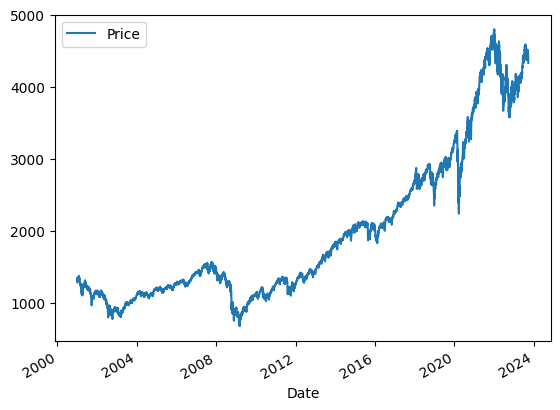

In [55]:
snp.plot(x='Date',y='Price')

<Axes: xlabel='month'>

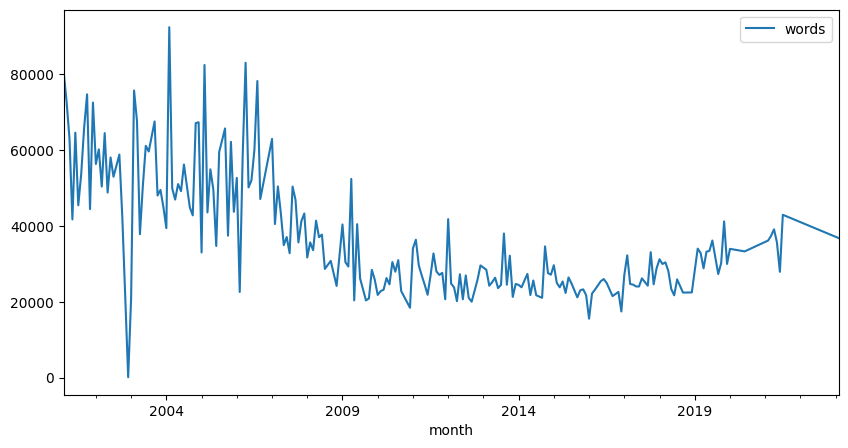

In [16]:
# word count by month
transcripts_word_count_by_month = transcripts_word_count.copy()
transcripts_word_count_by_month['month'] = transcripts_word_count_by_month['date'].dt.to_period('M')
transcripts_word_count_by_month = transcripts_word_count_by_month.groupby(by=['month'])['words'].mean().reset_index()
transcripts_word_count_by_month = transcripts_word_count_by_month[transcripts_word_count_by_month['month'] >= ('2000-01')]
transcripts_word_count_by_month.plot.line(x='month',y='words',figsize=(10,5))

In [57]:
# hearing unique word count
transcripts_word_count_unq = explode_df.copy().drop_duplicates()
transcripts_word_count_unq = transcripts_word_count_unq.groupby(by=['date','hearing_num'])['words'].count().reset_index()
transcripts_word_count_unq

date hearing_num  words
0    1993-07-01      103-35     87
1    1999-04-27      106-20   5318
2    1999-07-13      106-40   4912
3    2001-02-08       107-4   6299
4    2001-02-14      107-25   7652
...         ...         ...    ...
1599 2021-07-29      117-47   5107
1600 2023-02-01       118-2   5251
1601 2023-02-01       118-3   3945
1602 2023-02-02       118-5   3859
1603 2023-02-08       118-8   4865

[1604 rows x 3 columns]

Text(0.5, 1.0, 'unique word count boxplot by year')

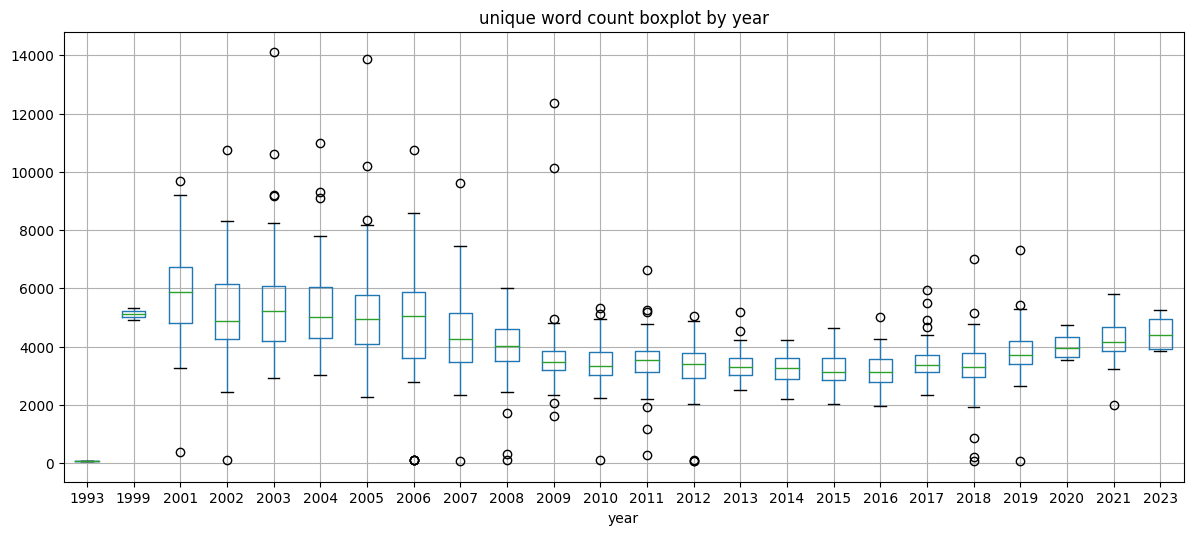

In [58]:
# unique word count by year
transcripts_word_count_unq_by_year = transcripts_word_count_unq.copy()
transcripts_word_count_unq_by_year['year'] = transcripts_word_count_unq_by_year['date'].dt.year
# year_groups = transcripts_word_count_by_year.groupby('year')
transcripts_word_count_unq_by_year.boxplot(column=['words'],by='year',figsize=(14,6))
plt.suptitle('')
plt.title('unique word count boxplot by year')

#### File - Oil-related word count

In [49]:
# oil-related keywords selected by Word2Vec
oil_keyword = ['petroleum','gas','crude','hydrocarbon','oilfield','gasoline','deepwater','petroleum','refineries','barrel']

In [59]:
# oil-related keyword
oil_df = explode_df.copy()
oil_df['oil_related'] = np.where((oil_df['words'].isin(oil_keyword)),True,False)
oil_df = oil_df.groupby(by=['date','hearing_num'])['oil_related'].sum().reset_index()
oil_df['month'] = oil_df['date'].dt.to_period('M')
oil_df

date hearing_num  oil_related    month
0    2001-02-08       107-4            1  2001-02
1    2001-02-14      107-25            2  2001-02
2    2001-02-15       107-1            1  2001-02
3    2001-02-15       107-7          119  2001-02
4    2001-02-28      107-11         1305  2001-02
...         ...         ...          ...      ...
1596 2021-07-29      117-47            0  2021-07
1597 2023-02-01       118-2            0  2023-02
1598 2023-02-01       118-3            1  2023-02
1599 2023-02-02       118-5            1  2023-02
1600 2023-02-08       118-8            2  2023-02

[1601 rows x 4 columns]

/tmp/ipykernel_395187/637770232.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  oil_price['date'] = pd.to_datetime(oil_price['date'])


<Axes: xlabel='month'>

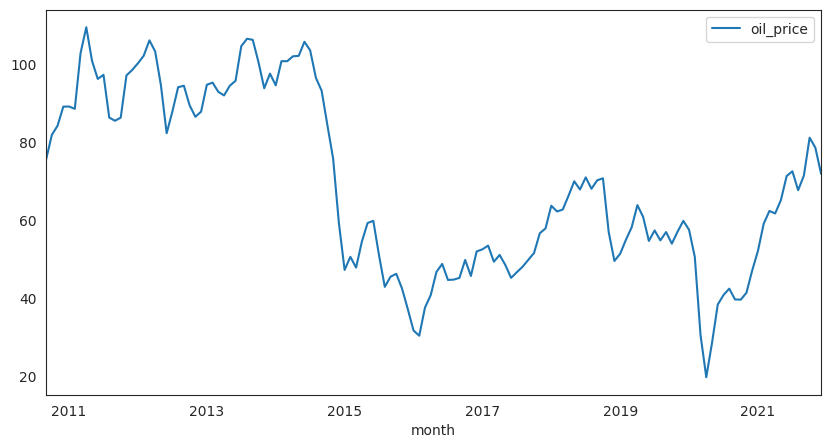

In [54]:
# oil price
oil_price = pd.read_csv('/home/congress-user/data_collection/EDA/supp_data/daily_crude_oil_price_10years.csv',on_bad_lines='skip')
oil_price['date'] = pd.to_datetime(oil_price['date'])
oil_price['month'] = oil_price['date'].dt.to_period('M')
oil_price = oil_price[(oil_price['date'] > '2010-01-01') & (oil_price['date'] < '2022-01-01')]
oil_price = oil_price.rename(columns={' value':'oil_price'})
oil_price = oil_price.groupby(by=['month'])['oil_price'].mean().reset_index()
oil_price.plot(x='month',y='oil_price',figsize=(10,5))

In [13]:
# VDE price
vde_price = pd.read_csv('/home/congress-user/data_collection/EDA/supp_data/VDE.csv',on_bad_lines='skip')
vde_price['Date'] = pd.to_datetime(vde_price['Date'])
vde_price['month'] = vde_price['Date'].dt.to_period('M')
vde_price = vde_price[(vde_price['Date'] > '2010-01-01') & (vde_price['Date'] < '2022-01-01')]
vde_price = vde_price[['Date','month','Close','Volume']]
vde_price

Date    month      Close  Volume
1325 2010-01-04  2010-01  85.970001  209200
1326 2010-01-05  2010-01  86.849998  182600
1327 2010-01-06  2010-01  87.849998  191300
1328 2010-01-07  2010-01  87.639999  138100
1329 2010-01-08  2010-01  88.300003  103400
...         ...      ...        ...     ...
4341 2021-12-27  2021-12  78.739998  754600
4342 2021-12-28  2021-12  78.559998  809400
4343 2021-12-29  2021-12  78.080002  802500
4344 2021-12-30  2021-12  77.379997  790900
4345 2021-12-31  2021-12  77.610001  770800

[3021 rows x 4 columns]

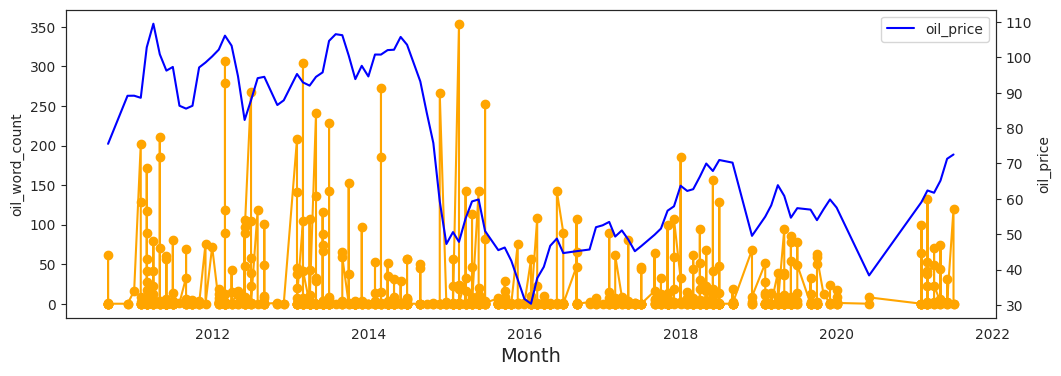

In [60]:
# oil-related word vs oil price
oil_join_df = oil_df.merge(oil_price)
oil_join_df['month'] = oil_join_df['month'].dt.to_timestamp()
# # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(oil_join_df['month'], oil_join_df['oil_related'], marker='o',color='orange',label='oil_word_count')
ax1.set_ylabel('oil_word_count')

ax2 = ax1.twinx()
ax2.plot(oil_join_df['month'], oil_join_df['oil_price'], color='blue',label='oil_price')
ax2.set_ylabel('oil_price')

ax1.set_xlabel('Month', fontsize=14)
# ax1.set_title('Revenue and Sales by Product', fontsize=16)

plt.legend()
plt.show()

In [65]:
# oil-related word vs oil price
oil_join_df = oil_df.merge(oil_price)
oil_join_df['Q'] = oil_join_df['date'].dt.to_period('Q')
oil_join_df['Q'] = oil_join_df['Q'].dt.to_timestamp()
oil_join_df = oil_join_df.groupby(by=['Q'])[['oil_related']]
# oil_join_df = oil_join_df.groupby()
# # # oil_join_df.plot(x='month',y=['oil_related','oil_price'])

# fig, ax1 = plt.subplots(figsize=(12,4))

# ax1.plot(oil_join_df['Q'], oil_join_df['oil_related'], marker='o',color='orange',label='oil_word_count')
# ax1.set_ylabel('oil_word_count')

# ax2 = ax1.twinx()
# ax2.plot(oil_join_df['Q'], oil_join_df['oil_price'], color='blue',label='oil_price')
# ax2.set_ylabel('oil_price')

# ax1.set_xlabel('Quarter', fontsize=14)
# # ax1.set_title('Revenue and Sales by Product', fontsize=16)

# plt.legend()
# plt.show()

date hearing_num  oil_related    month  oil_price          Q
0   2010-09-08     111-153            0  2010-09  75.553750 2010-07-01
1   2010-09-15     111-154            0  2010-09  75.553750 2010-07-01
2   2010-09-15     111-155            0  2010-09  75.553750 2010-07-01
3   2010-09-16     111-156            0  2010-09  75.553750 2010-07-01
4   2010-09-22     111-157            1  2010-09  75.553750 2010-07-01
..         ...         ...          ...      ...        ...        ...
865 2021-06-29      117-40           31  2021-06  71.321636 2021-04-01
866 2021-06-30      117-41            2  2021-06  71.321636 2021-04-01
867 2021-07-27      117-45          120  2021-07  72.537636 2021-07-01
868 2021-07-28      117-46            0  2021-07  72.537636 2021-07-01
869 2021-07-29      117-47            0  2021-07  72.537636 2021-07-01

[870 rows x 6 columns]

In [11]:
oil_df['oil_related'].describe()

count    1604.000000
mean       12.024314
std        51.170346
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       732.000000
Name: oil_related, dtype: float64

In [3]:
# gas price
gas_price = pd.read_csv('/home/congress-user/data_collection/EDA/supp_data/daily_gas_price_10years.csv')
gas_price

date   value
0     22/09/2010    4.02
1     23/09/2010    4.08
2     24/09/2010    3.97
3     27/09/2010    3.80
4     28/09/2010    3.80
...          ...     ...
3304  06/10/2023     NaN
3305  07/10/2023     NaN
3306  08/10/2023     NaN
3307  09/10/2023     NaN
3308  10/10/2023     NaN

[3309 rows x 2 columns]

In [8]:
# gas-related keyword
gas_df = explode_df.copy()
gas_df['gas_related'] = np.where((gas_df['words'] == 'gas'),True,False)
gas_df = gas_df.groupby(by=['date','hearing_num'])['gas_related'].sum().reset_index()
gas_df

date hearing_num  gas_related
0     1993-07-01      103-35            0
1     1999-04-27      106-20            0
2     1999-07-13      106-40            1
3     2001-02-08       107-4            0
4     2001-02-14      107-25            0
...          ...         ...          ...
1599  2021-07-29      117-47            0
1600  2023-02-01       118-2            0
1601  2023-02-01       118-3            1
1602  2023-02-02       118-5            1
1603  2023-02-08       118-8            2

[1604 rows x 3 columns]

<Axes: xlabel='date'>

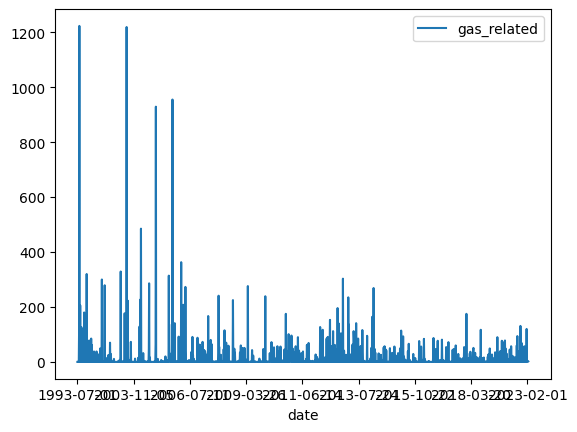

In [9]:
gas_df.plot(x='date',y='gas_related')